In [682]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [683]:
circuits = pd.read_csv('circuits.csv')
constructor_results = pd.read_csv('constructor_results.csv')
constructors_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
drivers_standings = pd.read_csv('driver_standings.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
seasons = pd.read_csv('seasons.csv')
status = pd.read_csv('status.csv')

In [684]:
def getMiliSeconds(time):
    try:
        if '.' in time:
            x = datetime.datetime.strptime(time,'%M:%S.%f')
        elif ',' in time:
            x = datetime.datetime.strptime(time,'%M:%S,%f')
        else:
            x = datetime.datetime.strptime(time,'%M:%S:%f')
        return datetime.timedelta(minutes=x.minute,seconds=x.second, microseconds = x.microsecond).total_seconds()
    except:
        x = datetime.datetime.strptime(str(time).split('.')[0],'%M:%S:%f')
        return datetime.timedelta(minutes=x.minute,seconds=x.second, microseconds = x.microsecond).total_seconds()

def timefn(x):
    if (x.find(':') != -1):
        return getMiliSeconds(x)
    else:
        return x

results['fastestLapTime'] = results['fastestLapTime'].replace('0','00:00.0')
qualifying['q1'] = qualifying['q1'].replace('0','00:00.0')
qualifying['q2'] = qualifying['q2'].replace('0','00:00.0')
qualifying['q3'] = qualifying['q3'].replace('0','00:00.0')

qualifying['q1'] = qualifying['q1'].apply(lambda x: getMiliSeconds(x))
qualifying['q2'] = qualifying['q2'].apply(lambda x: getMiliSeconds(x))
qualifying['q3'] = qualifying['q3'].apply(lambda x: getMiliSeconds(x))
lap_times['time'] = lap_times['time'].apply(lambda x: getMiliSeconds(x))
results['fastestLapTime'] = results['fastestLapTime'].apply(lambda x: getMiliSeconds(x))

pit_stops['duration'] = pit_stops['duration'].apply(lambda x: timefn(x))

drivers['fullName'] = drivers['forename'] + " " + drivers['surname']

In [685]:
data = pd.merge(results, qualifying, on = ['raceId', 'driverId','constructorId'], how = 'left')
data = pd.merge(data, races, on = 'raceId', how = 'left')
data = pd.merge(data, drivers, on = 'driverId', how = 'left')
data = pd.merge(data, constructors, on = 'constructorId', how = 'left')
data = pd.merge(data, circuits, on = 'circuitId', how = 'left')
data = data[['year', 'round', 'circuitId', 'circuitRef', 'name', 'name_x', 'lat', 'lng', 'resultId', 'raceId', 'driverId', 'driverRef',
             'fullName', 'dob', 'nationality_x', 'constructorId', 'constructorRef', 'name_y', 'nationality_y',
             'q1', 'q2', 'q3','grid', 'position_x', 'positionOrder', 'laps', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
             'fastestLapSpeed', 'statusId']]
data = data.rename(columns = {'round':'roundNum', 'name': 'circuitName', 'name_x': 'GrandPrix', 'nationality_x': 'driverNationality',
                              'name_y': 'constructor', 'nationality_y': 'constructorNationality', 'position_x': 'finishingPos', 
                              'rank':'fastestLapRank', 'milliseconds':'raceTime'}, inplace = False)
data = pd.merge(data, constructors_standings, on = ['constructorId', 'raceId'], how = 'left')
data = data.rename(columns = {'points': 'constructorPoints', 'position': 'constructorPosition', 'wins': 'constructorWins'}, inplace = False)
data = data.drop(['constructorStandingsId', 'positionText'], axis = 1, inplace = False)
data = pd.merge(data, drivers_standings, on = ['driverId', 'raceId'], how = 'left')
data = data.rename(columns = {'points': 'driverPoints', 'position': 'driverPosition', 'wins': 'driverWins'}, inplace = False)
data = data.drop(['driverStandingsId', 'positionText'], axis = 1, inplace = False)
pit_stop_count = pd.DataFrame(pit_stops.groupby(['raceId', 'driverId']).count())
data = pd.merge(data, pit_stop_count, on = ['raceId','driverId'], how = 'left')
data = data.drop(['lap', 'time', 'duration', 'milliseconds'], axis = 1, inplace = False)
pit_stops['duration'] = pit_stops['duration'].astype(float)
pit_stop_duration_mean = pit_stops.groupby(['raceId', 'driverId']).mean()
data = pd.merge(data, pit_stop_duration_mean, on = ['raceId','driverId'], how = 'left')
data = data.rename(columns = {'stop_x': 'pitStops', 'duration': 'pitStopDuration'}, inplace = False)
data = data.drop(['stop_y', 'lap', 'milliseconds'], axis = 1, inplace = False)
data['birth_year'] = pd.DatetimeIndex(data['dob']).year
data['dob'] =  data.year - data.birth_year
data = data.rename(columns = {'dob':'age'}, inplace = False)
data = data.drop(['birth_year'], axis = 1, inplace = False)
data = data[['year', 'roundNum', 'circuitId', 'circuitRef', 'circuitName', 'lat', 'lng', 'GrandPrix', 'resultId', 'raceId',
             'driverId', 'driverRef', 'fullName', 'age', 'driverNationality', 'constructorId', 'constructorRef',
             'constructor', 'constructorNationality', 'q1', 'q2', 'q3', 'grid', 'finishingPos', 'positionOrder',
             'laps', 'raceTime', 'fastestLap', 'fastestLapRank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'pitStops', 'pitStopDuration',
             'constructorPoints', 'constructorPosition', 'constructorWins','driverPoints', 'driverPosition', 'driverWins']]
data = data.sort_values(['year','roundNum'])
pd.set_option('display.max_columns', 500)
data.head()

year  roundNum  circuitId   circuitRef          circuitName      lat  \
20024  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20025  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20026  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20027  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20028  1950         1          9  silverstone  Silverstone Circuit  52.0786   

           lng           GrandPrix  resultId  raceId  driverId    driverRef  \
20024 -1.01694  British Grand Prix     20025     833       642       farina   
20025 -1.01694  British Grand Prix     20026     833       786      fagioli   
20026 -1.01694  British Grand Prix     20027     833       686  reg_parnell   
20027 -1.01694  British Grand Prix     20028     833       704    cabantous   
20028 -1.01694  British Grand Prix     20029     833       627       rosier   

             fullName  age driverNationality  constructorId constructorRef  \
20024     Nino Farina   44           Italian             51           alfa   
20025   Luigi Fagioli   52           Italian             51           alfa   
20026     Reg Parnell   39           British             51           alfa   
20027  Yves Cabantous   46            French            154           lago   
20028    Louis Rosier   45            French            154           lago   

       constructor constructorNationality  q1  q2  q3  grid  finishingPos  \
20024   Alfa Romeo                Italian NaN NaN NaN     1             1   
20025   Alfa Romeo                Italian NaN NaN NaN     2             2   
20026   Alfa Romeo                Italian NaN NaN NaN     4             3   
20027  Talbot-Lago                 French NaN NaN NaN     6             4   
20028  Talbot-Lago                 French NaN NaN NaN     9             5   

       positionOrder  laps  raceTime  fastestLap  fastestLapRank  \
20024              1    70   8003600           0               0   
20025              2    70   8006200           0               0   
20026              3    70   8055600           0               0   
20027              4    68         0           0               0   
20028              5    68         0           0               0   

       fastestLapTime  fastestLapSpeed  statusId  pitStops  pitStopDuration  \
20024             0.0              0.0         1       NaN              NaN   
20025             0.0              0.0         1       NaN              NaN   
20026             0.0              0.0         1       NaN              NaN   
20027             0.0              0.0        12       NaN              NaN   
20028             0.0              0.0        12       NaN              NaN   

       constructorPoints  constructorPosition  constructorWins  driverPoints  \
20024                NaN                  NaN              NaN           9.0   
20025                NaN                  NaN              NaN           6.0   
20026                NaN                  NaN              NaN           4.0   
20027                NaN                  NaN              NaN           3.0   
20028                NaN                  NaN              NaN           2.0   

       driverPosition  driverWins  
20024             1.0         1.0  
20025             2.0         0.0  
20026             3.0         0.0  
20027             4.0         0.0  
20028             5.0         0.0

In [686]:
data.tail()

year  roundNum  circuitId circuitRef                    circuitName  \
24935  2020        16          3    bahrain  Bahrain International Circuit   
24936  2020        16          3    bahrain  Bahrain International Circuit   
24937  2020        16          3    bahrain  Bahrain International Circuit   
24938  2020        16          3    bahrain  Bahrain International Circuit   
24939  2020        16          3    bahrain  Bahrain International Circuit   

           lat      lng          GrandPrix  resultId  raceId  driverId  \
24935  26.0325  50.5106  Sakhir Grand Prix     24941    1046       851   
24936  26.0325  50.5106  Sakhir Grand Prix     24942    1046       850   
24937  26.0325  50.5106  Sakhir Grand Prix     24943    1046       849   
24938  26.0325  50.5106  Sakhir Grand Prix     24944    1046       830   
24939  26.0325  50.5106  Sakhir Grand Prix     24945    1046       844   

               driverRef           fullName  age driverNationality  \
24935             aitken        Jack Aitken   25           British   
24936  pietro_fittipaldi  Pietro Fittipaldi   24         Brazilian   
24937             latifi    Nicholas Latifi   25          Canadian   
24938     max_verstappen     Max Verstappen   23             Dutch   
24939            leclerc    Charles Leclerc   23        Monegasque   

       constructorId constructorRef   constructor constructorNationality  \
24935              3       williams      Williams                British   
24936            210           haas  Haas F1 Team               American   
24937              3       williams      Williams                British   
24938              9       red_bull      Red Bull               Austrian   
24939              6        ferrari       Ferrari                Italian   

         q1    q2    q3  grid  finishingPos  positionOrder  laps  raceTime  \
24935  54.9   0.0   0.0    17            16             16    87   5508788   
24936  55.4   0.0   0.0    20            17             17    87   5511972   
24937  54.8   0.0   0.0    16             0             18    52         0   
24938  54.0  53.6  53.4     3             0             19     0         0   
24939  54.2  53.8  53.6     4             0             20     0         0   

       fastestLap  fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  \
24935          56              15            57.4          222.240         1   
24936          56              17            57.7          220.892         1   
24937          29              18            58.2          219.132         5   
24938           0               0             0.0            0.000         3   
24939           0               0             0.0            0.000         4   

       pitStops  pitStopDuration  constructorPoints  constructorPosition  \
24935       3.0           30.193                0.0                 10.0   
24936       3.0           26.618                3.0                  9.0   
24937       1.0           24.297                0.0                 10.0   
24938       NaN              NaN              282.0                  2.0   
24939       NaN              NaN              131.0                  6.0   

       constructorWins  driverPoints  driverPosition  driverWins  
24935              0.0           0.0            22.0         0.0  
24936              0.0           0.0            23.0         0.0  
24937              0.0           0.0            21.0         0.0  
24938              1.0         189.0             3.0         1.0  
24939              0.0          98.0             6.0         0.0

In [687]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24940 entries, 20024 to 24939
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    24940 non-null  int64  
 1   roundNum                24940 non-null  int64  
 2   circuitId               24940 non-null  int64  
 3   circuitRef              24940 non-null  object 
 4   circuitName             24940 non-null  object 
 5   lat                     24940 non-null  float64
 6   lng                     24940 non-null  float64
 7   GrandPrix               24940 non-null  object 
 8   resultId                24940 non-null  int64  
 9   raceId                  24940 non-null  int64  
 10  driverId                24940 non-null  int64  
 11  driverRef               24940 non-null  object 
 12  fullName                24940 non-null  object 
 13  age                     24940 non-null  int64  
 14  driverNationality       24940 non-

In [688]:
data.head()

year  roundNum  circuitId   circuitRef          circuitName      lat  \
20024  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20025  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20026  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20027  1950         1          9  silverstone  Silverstone Circuit  52.0786   
20028  1950         1          9  silverstone  Silverstone Circuit  52.0786   

           lng           GrandPrix  resultId  raceId  driverId    driverRef  \
20024 -1.01694  British Grand Prix     20025     833       642       farina   
20025 -1.01694  British Grand Prix     20026     833       786      fagioli   
20026 -1.01694  British Grand Prix     20027     833       686  reg_parnell   
20027 -1.01694  British Grand Prix     20028     833       704    cabantous   
20028 -1.01694  British Grand Prix     20029     833       627       rosier   

             fullName  age driverNationality  constructorId constructorRef  \
20024     Nino Farina   44           Italian             51           alfa   
20025   Luigi Fagioli   52           Italian             51           alfa   
20026     Reg Parnell   39           British             51           alfa   
20027  Yves Cabantous   46            French            154           lago   
20028    Louis Rosier   45            French            154           lago   

       constructor constructorNationality  q1  q2  q3  grid  finishingPos  \
20024   Alfa Romeo                Italian NaN NaN NaN     1             1   
20025   Alfa Romeo                Italian NaN NaN NaN     2             2   
20026   Alfa Romeo                Italian NaN NaN NaN     4             3   
20027  Talbot-Lago                 French NaN NaN NaN     6             4   
20028  Talbot-Lago                 French NaN NaN NaN     9             5   

       positionOrder  laps  raceTime  fastestLap  fastestLapRank  \
20024              1    70   8003600           0               0   
20025              2    70   8006200           0               0   
20026              3    70   8055600           0               0   
20027              4    68         0           0               0   
20028              5    68         0           0               0   

       fastestLapTime  fastestLapSpeed  statusId  pitStops  pitStopDuration  \
20024             0.0              0.0         1       NaN              NaN   
20025             0.0              0.0         1       NaN              NaN   
20026             0.0              0.0         1       NaN              NaN   
20027             0.0              0.0        12       NaN              NaN   
20028             0.0              0.0        12       NaN              NaN   

       constructorPoints  constructorPosition  constructorWins  driverPoints  \
20024                NaN                  NaN              NaN           9.0   
20025                NaN                  NaN              NaN           6.0   
20026                NaN                  NaN              NaN           4.0   
20027                NaN                  NaN              NaN           3.0   
20028                NaN                  NaN              NaN           2.0   

       driverPosition  driverWins  
20024             1.0         1.0  
20025             2.0         0.0  
20026             3.0         0.0  
20027             4.0         0.0  
20028             5.0         0.0

In [689]:
data = data.replace(np.nan, 0)

In [690]:
data_10 = data.copy()
data_10 = data_10[data_10['year']>2009]
data_10.head()

year  roundNum  circuitId circuitRef                    circuitName  \
20320  2010         1          3    bahrain  Bahrain International Circuit   
20321  2010         1          3    bahrain  Bahrain International Circuit   
20322  2010         1          3    bahrain  Bahrain International Circuit   
20323  2010         1          3    bahrain  Bahrain International Circuit   
20324  2010         1          3    bahrain  Bahrain International Circuit   

           lat      lng           GrandPrix  resultId  raceId  driverId  \
20320  26.0325  50.5106  Bahrain Grand Prix     20323     337         4   
20321  26.0325  50.5106  Bahrain Grand Prix     20324     337        13   
20322  26.0325  50.5106  Bahrain Grand Prix     20325     337         1   
20323  26.0325  50.5106  Bahrain Grand Prix     20326     337        20   
20324  26.0325  50.5106  Bahrain Grand Prix     20327     337         3   

      driverRef          fullName  age driverNationality  constructorId  \
20320    alonso   Fernando Alonso   29           Spanish              6   
20321     massa      Felipe Massa   29         Brazilian              6   
20322  hamilton    Lewis Hamilton   25           British              1   
20323    vettel  Sebastian Vettel   23            German              9   
20324   rosberg      Nico Rosberg   25            German            131   

      constructorRef constructor constructorNationality     q1     q2     q3  \
20320        ferrari     Ferrari                Italian  114.6  114.2  114.6   
20321        ferrari     Ferrari                Italian  115.3  114.3  114.2   
20322        mclaren     McLaren                British  115.3  114.7  115.2   
20323       red_bull    Red Bull               Austrian  115.0  113.9  114.1   
20324       mercedes    Mercedes                 German  115.5  114.7  115.2   

       grid  finishingPos  positionOrder  laps  raceTime  fastestLap  \
20320     3             1              1    49   5960396          45   
20321     2             2              2    49   5976495          38   
20322     4             3              3    49   5983578          42   
20323     1             4              4    49   5999195          32   
20324     5             5              5    49   6000609          45   

       fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  pitStops  \
20320               1           118.3          191.706         1       0.0   
20321               5           119.7          189.392         1       0.0   
20322               4           119.6          189.665         1       0.0   
20323              12           120.2          188.627         1       0.0   
20324              13           120.2          188.599         1       0.0   

       pitStopDuration  constructorPoints  constructorPosition  \
20320              0.0               43.0                  1.0   
20321              0.0               43.0                  1.0   
20322              0.0               21.0                  2.0   
20323              0.0               16.0                  4.0   
20324              0.0               18.0                  3.0   

       constructorWins  driverPoints  driverPosition  driverWins  
20320              1.0          25.0             1.0         1.0  
20321              1.0          18.0             2.0         0.0  
20322              0.0          15.0             3.0         0.0  
20323              0.0          12.0             4.0         0.0  
20324              0.0          10.0             5.0         0.0

# Exploratory Data Analysis

Data analysis of the various race cuircuits, constructors and drivers

In [691]:
tracks = [{'lat': circuits['lat'], 'lon': circuits['lng'],
         'marker': {'color': 'orangered','line': {'color': 'black', 'width': 0.5}, 'size': 10,
                    'sizemode': 'diameter'}, 'text': '0.387', 'type': 'scattergeo'},]

layout = go.Layout(title = 'Circuits World Location', showlegend = False,
                   geo = dict(scope='world', projection = dict( type = 'natural earth'), showland = True,
                              landcolor = 'navajowhite', subunitwidth = 1, countrywidth = 1, 
                              subunitcolor = "navajowhite", countrycolor = "navajowhite"),
                   paper_bgcolor = 'white', plot_bgcolor = 'lightgrey')

fig =  go.Figure(layout = layout, data = tracks)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, validate = False)

In [692]:
races_count = data['GrandPrix'].value_counts()
trace = go.Pie(labels = races_count.index, values = races_count.values, hole = 0.6, textinfo = "none")
layout = go.Layout(title = 'Percentage of races by Location', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

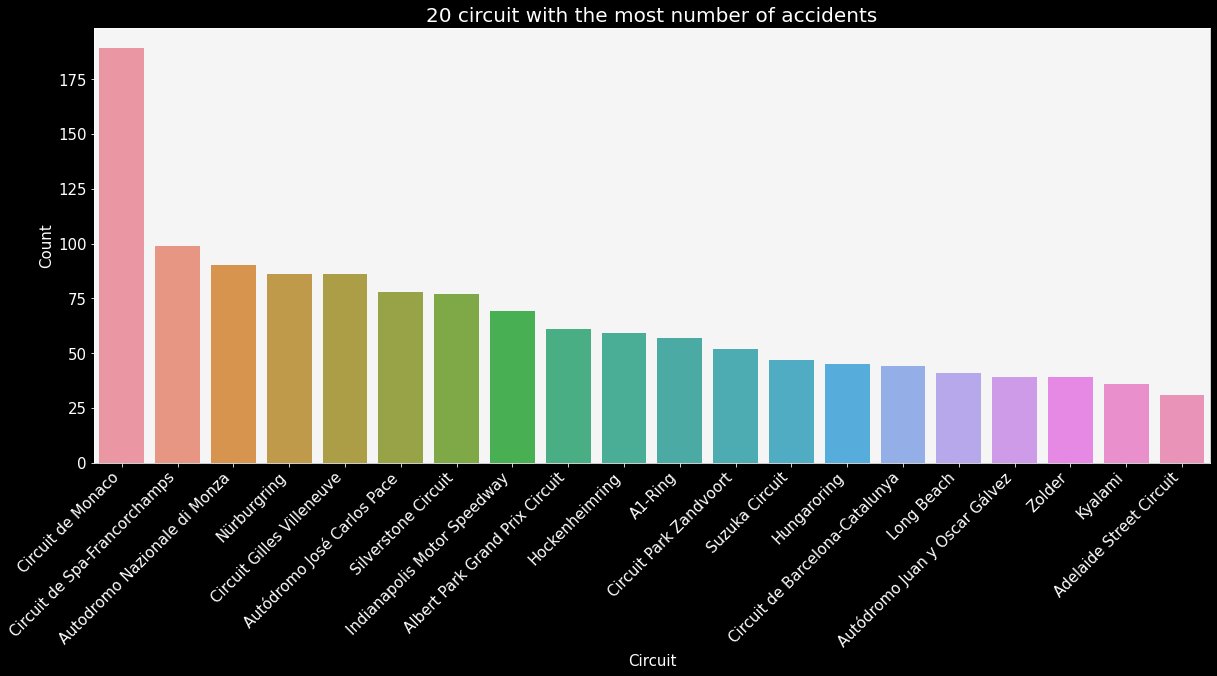

In [693]:
dangerousCircuits = data.loc[(data['statusId'] == 3) | (data['statusId'] == 4)]['circuitName'].value_counts()[:20]

plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 8))
axs.tick_params(axis="x", labelsize = 15)
axs.tick_params(axis="y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(dangerousCircuits.index, dangerousCircuits.values)
plt.title("20 circuit with the most number of accidents", fontsize = 20)
plt.xlabel('Circuit', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

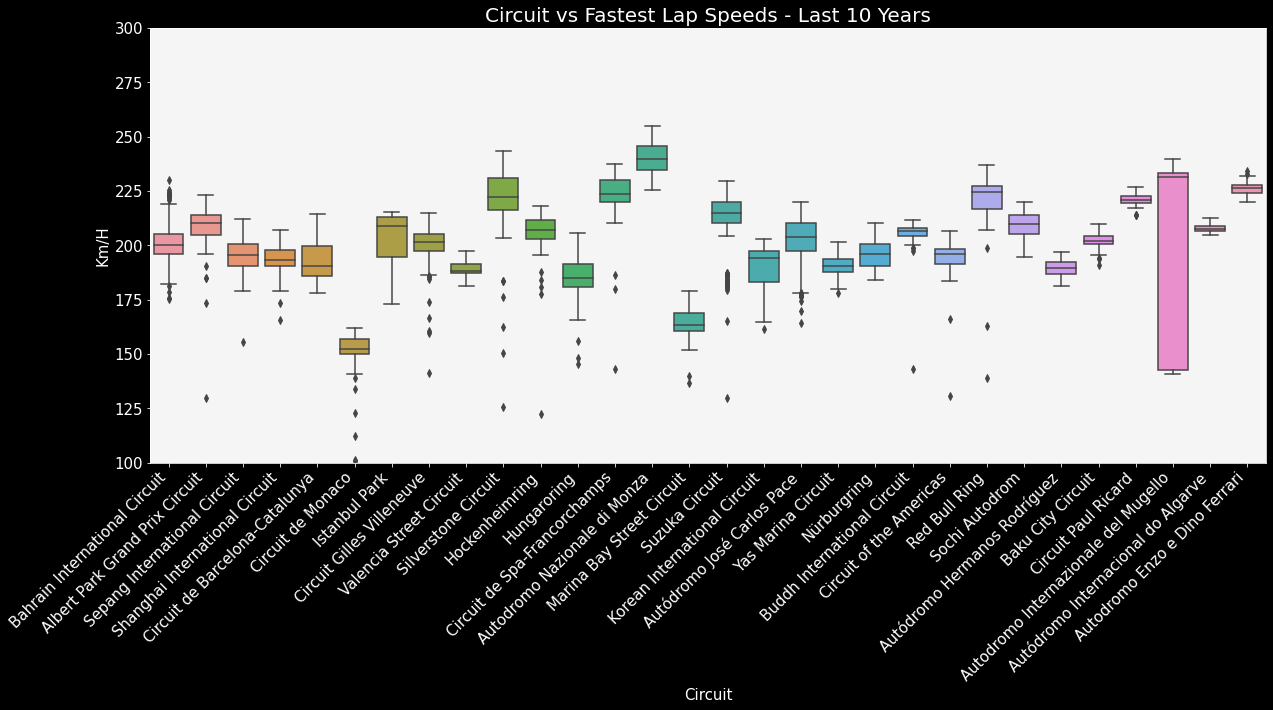

In [694]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 8))
axs.tick_params(axis="x", labelsize = 15)
axs.tick_params(axis="y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'fastestLapSpeed', data = data_10)
plt.ylim(100, 300)
plt.title("Circuit vs Fastest Lap Speeds - Last 10 Years", fontsize = 20)
plt.xlabel('Circuit', fontsize = 15)
plt.ylabel('Km/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

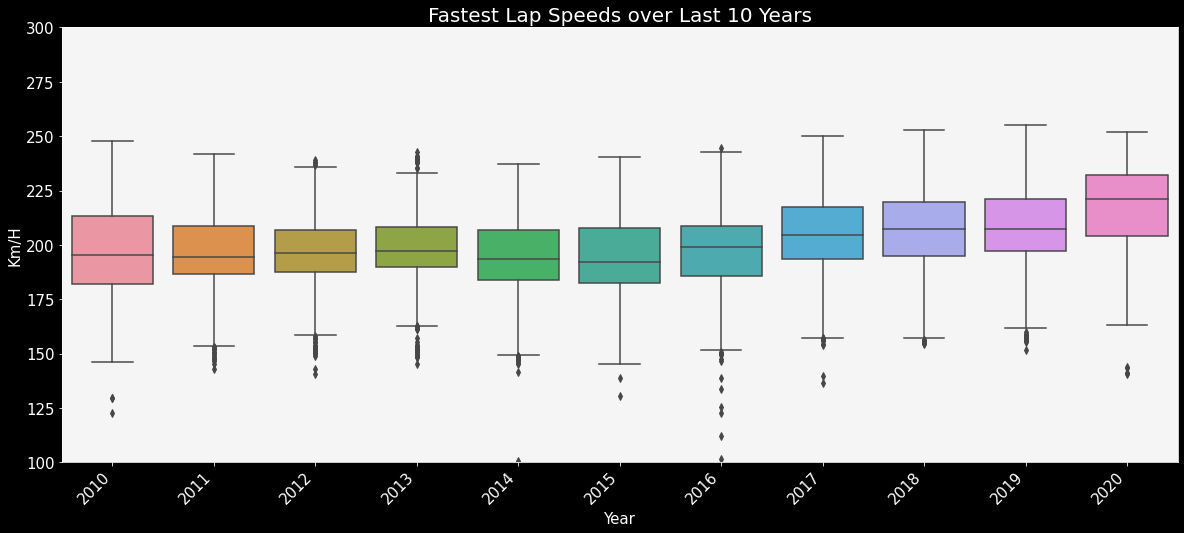

In [695]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'year', y = 'fastestLapSpeed', data = data_10)
plt.ylim(100, 300)
plt.title("Fastest Lap Speeds over Last 10 Years", fontsize = 20)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Km/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

We can see that the lap speeds have increased obviously over the last 10 years. However, we see that post 2014, the average speeds have risen faster per year post the 1.6 V6 Turbo Engine rule change. Could be due to the MGU-K and MGU-H introduction 

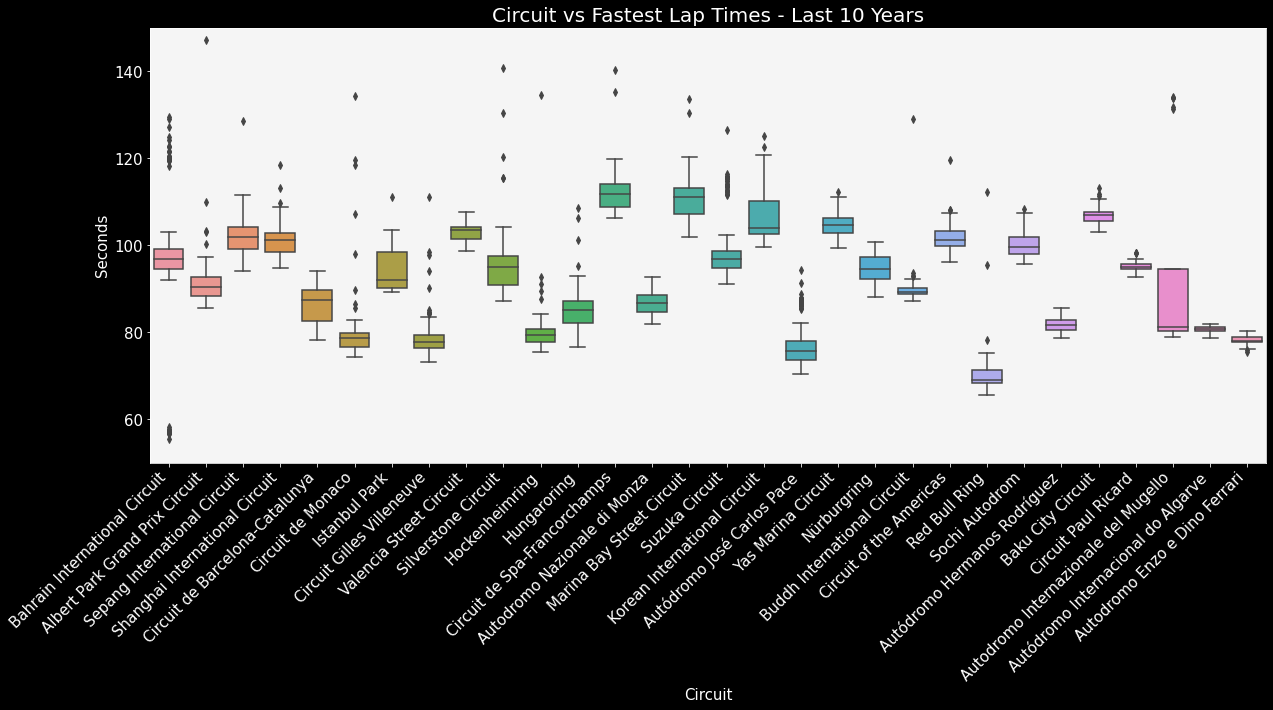

In [696]:
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'fastestLapTime', data = data_10)
plt.ylim(50, 150)
plt.title("Circuit vs Fastest Lap Times - Last 10 Years", fontsize = 20)
plt.xlabel('Circuit', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

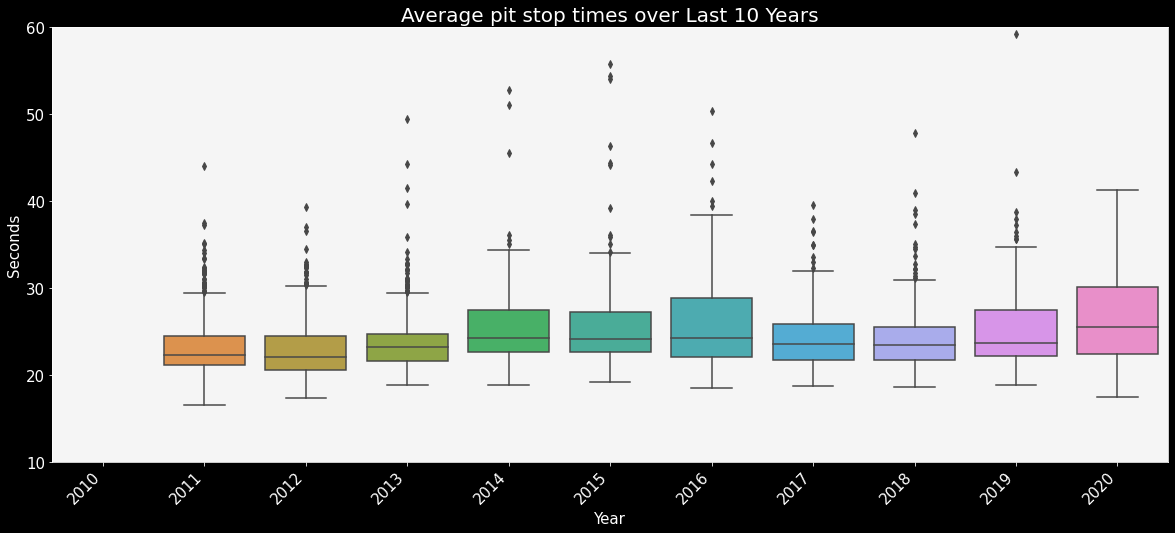

In [697]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'year', y = 'pitStopDuration', data = data_10)
plt.ylim(10, 60)
plt.title("Average pit stop times over Last 10 Years", fontsize = 20)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Oddly, average pit stop durations have increased over the years

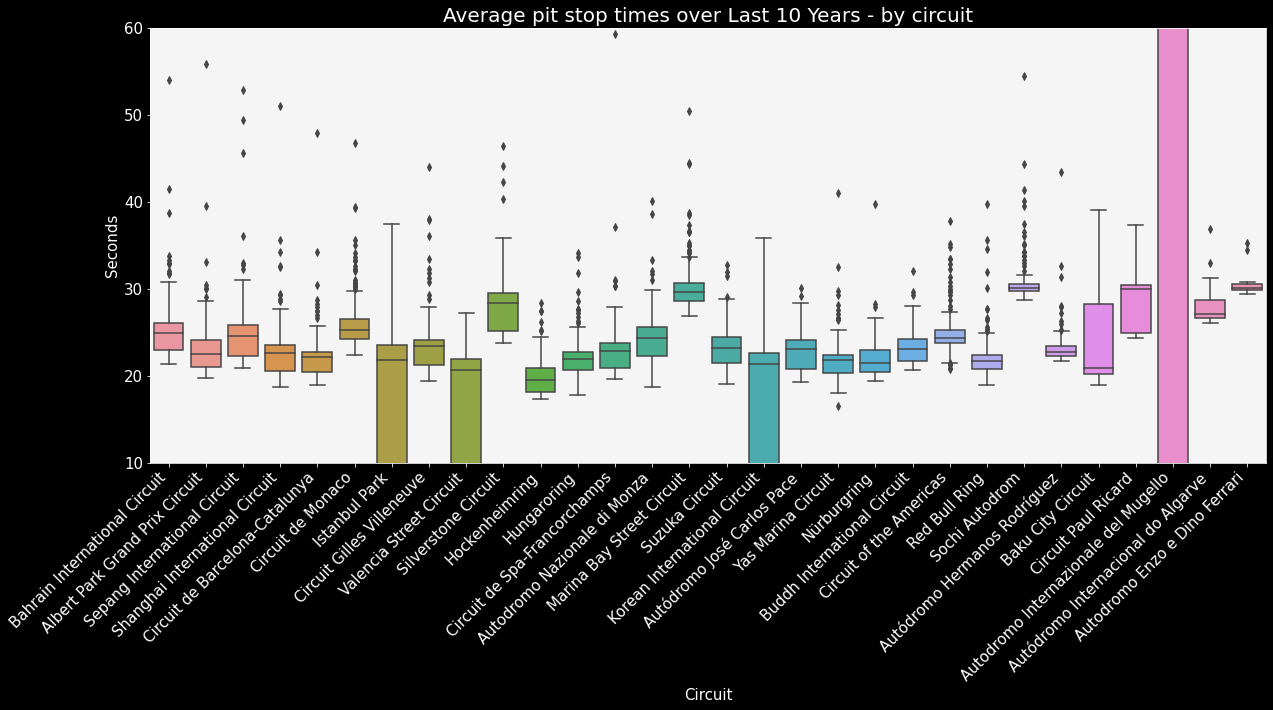

In [698]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'pitStopDuration', data = data_10)
plt.ylim(10, 60)
plt.title("Average pit stop times over Last 10 Years - by circuit", fontsize = 20)
plt.xlabel('Circuit',fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

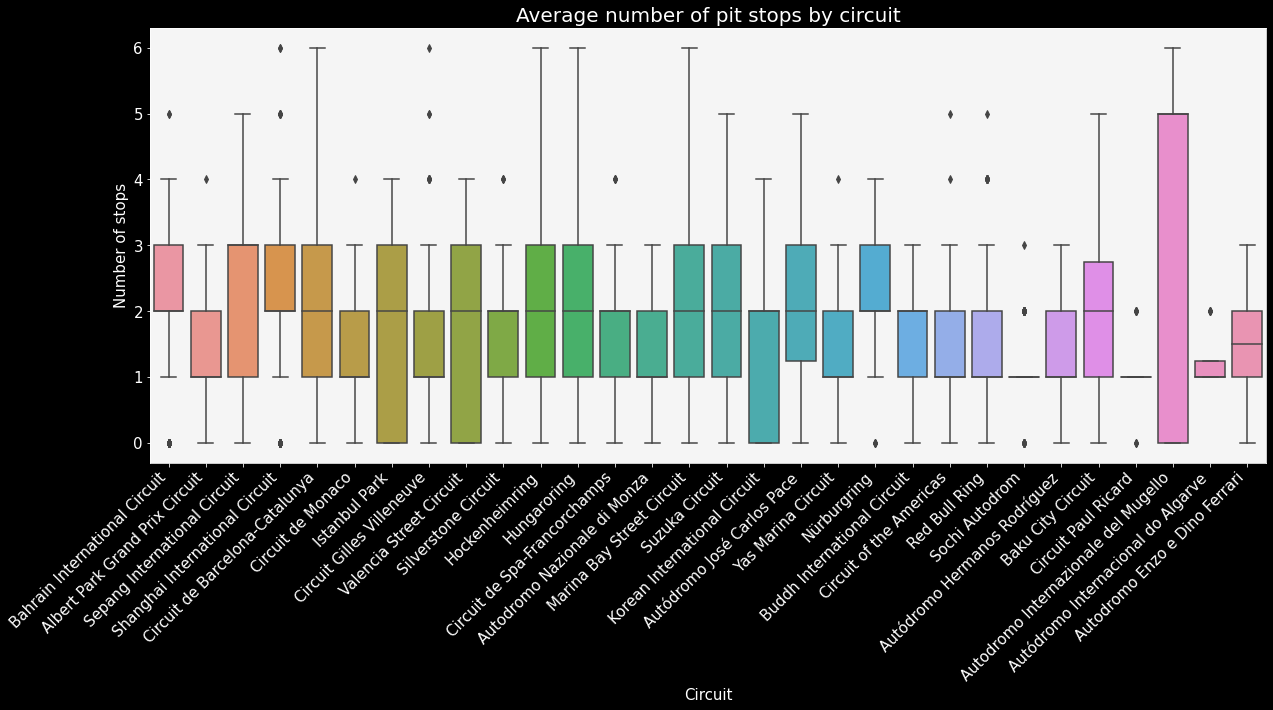

In [699]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'circuitName', y = 'pitStops', data = data_10)
plt.title("Average number of pit stops by circuit", fontsize = 20)
plt.xlabel('Circuit',fontsize = 15)
plt.ylabel('Number of stops', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [700]:
constructors_count = data.drop_duplicates(subset = ["constructorId"])
constructors_count = constructors_count['constructorNationality'].value_counts()
trace = go.Pie(labels = constructors_count.index, values = constructors_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Percentage of Constructors by Nationality', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

In [701]:
drivers_count = data.drop_duplicates(subset = ["driverId"])
drivers_count = drivers_count['driverNationality'].value_counts()
trace = go.Pie(labels = drivers_count.index, values = drivers_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Percentage of Drivers by Nationality', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

In [702]:
driver_age = data.drop_duplicates(subset = ["driverId"])
driver_age_dist_count = driver_age['age'].value_counts()

trace = go.Pie(labels = driver_age_dist_count.index, values = driver_age_dist_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Age wise race debutants', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

young_debutants = driver_age.sort_values('age')[:20]
young_debutants = young_debutants[['fullName', 'age', 'year', 'GrandPrix', 'constructor']]
print("Youngest Debutants")
young_debutants

Youngest Debutants


fullName  age  year                 GrandPrix     constructor
17624      Thomas Monarch   18  1963        Mexican Grand Prix    Lotus-Climax
22546      Max Verstappen   18  2015     Australian Grand Prix      Toro Rosso
18023   Ricardo Rodríguez   19  1961        Italian Grand Prix         Ferrari
12290      Mike Thackwell   19  1980          Dutch Grand Prix          Arrows
23389        Lance Stroll   19  2017     Australian Grand Prix        Williams
7747    Jaime Alguersuari   19  2009      Hungarian Grand Prix      Toro Rosso
22135        Daniil Kvyat   20  2014     Australian Grand Prix      Toro Rosso
2567      Fernando Alonso   20  2001     Australian Grand Prix         Minardi
12804       Eddie Cheever   20  1978      Argentine Grand Prix        Theodore
4423        Tarso Marques   20  1996      Brazilian Grand Prix         Minardi
2940        Jenson Button   20  2000     Australian Grand Prix        Williams
20080        Troy Ruttman   20  1950          Indianapolis 500        Lesovsky
3669        Esteban Tuero   20  1998     Australian Grand Prix         Minardi
17409          Chris Amon   20  1963         Monaco Grand Prix            Lola
507      Sebastian Vettel   20  2007  United States Grand Prix      BMW Sauber
24208        Lando Norris   20  2019     Australian Grand Prix         McLaren
23191        Esteban Ocon   20  2016        Belgian Grand Prix  Manor Marussia
5596   Rubens Barrichello   21  1993  South African Grand Prix          Jordan
19654       Peter Collins   21  1952          Swiss Grand Prix             HWM
18639       Bruce McLaren   21  1958         German Grand Prix          Cooper

# Hamilton's Performance Analysis

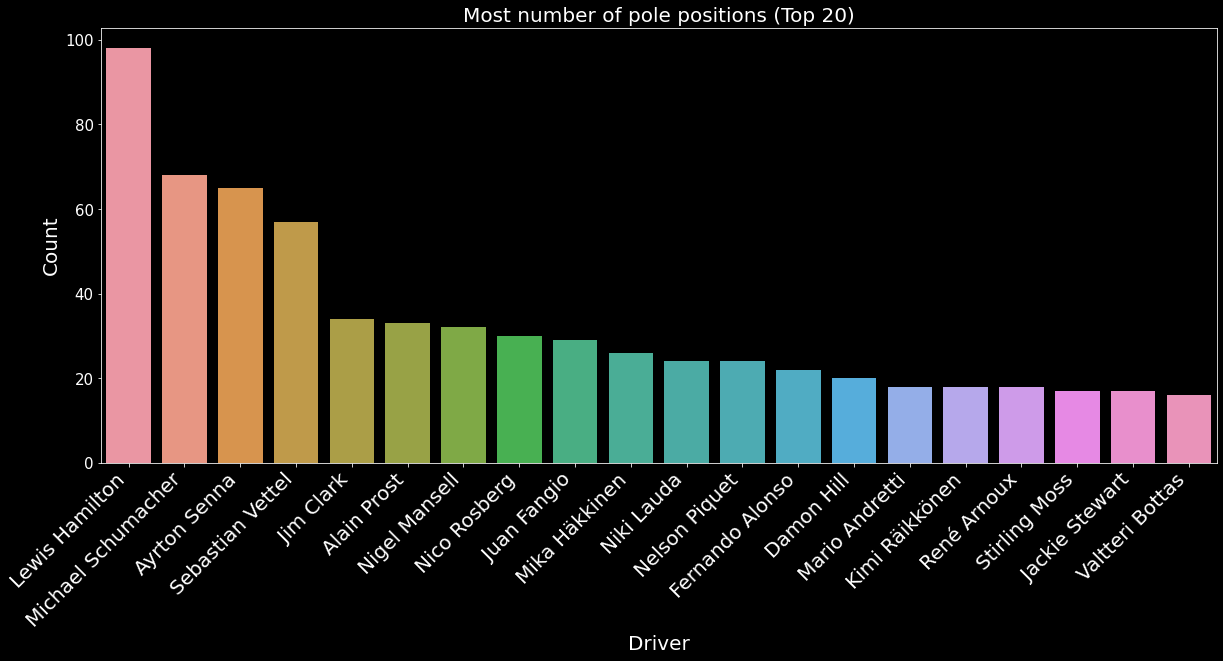

In [703]:
polesitters = data.loc[data['grid'] == 1].groupby('fullName')['grid'].count().sort_values(ascending = False)[:20]

fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 15)

sns.barplot(list(polesitters.index), list(polesitters.values))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Most number of pole positions (Top 20)", fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Driver', fontsize = 20)
plt.show()

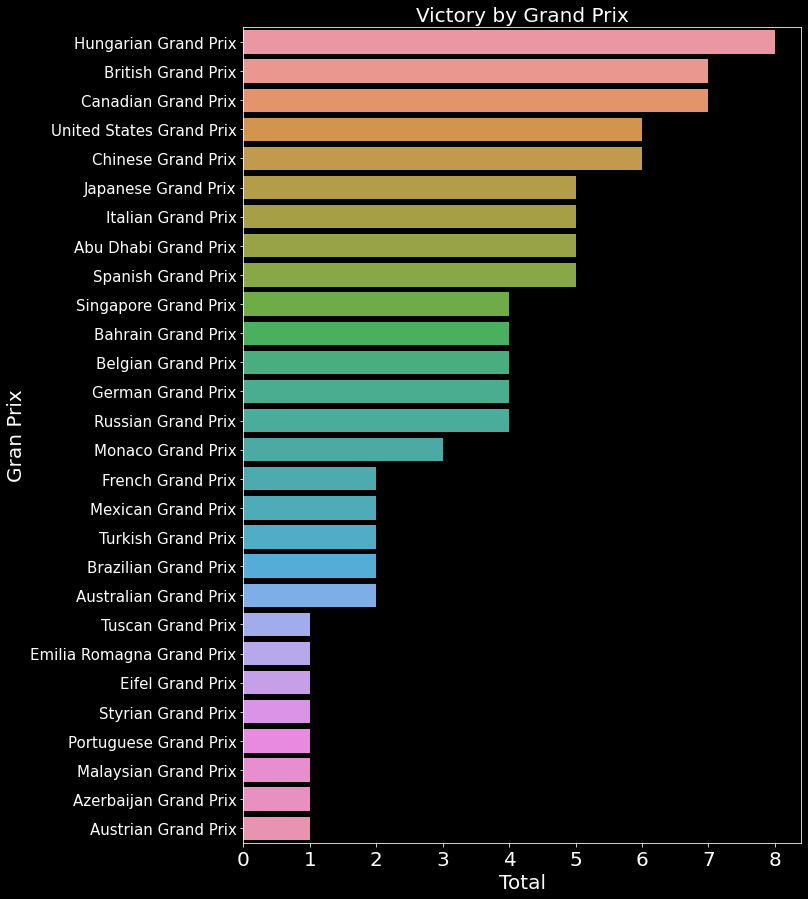

In [704]:
ham_wins = data.loc[(data['driverId'] == 1) & (data['positionOrder'] == 1)].groupby('GrandPrix')['driverId'].count().sort_values(ascending = False)

fig, axs = plt.subplots(figsize = (10, 15))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 15)

sns.barplot(list(ham_wins.values), list(ham_wins.index))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Victory by Grand Prix", fontsize = 20)
plt.ylabel('Gran Prix', fontsize = 20)
plt.xlabel('Total', fontsize = 20)
plt.show()

Interestingly HAM has won more Hungarian GPs than on homeground at Silverstone (British GP)

Let's see how he performs compared to some other legends

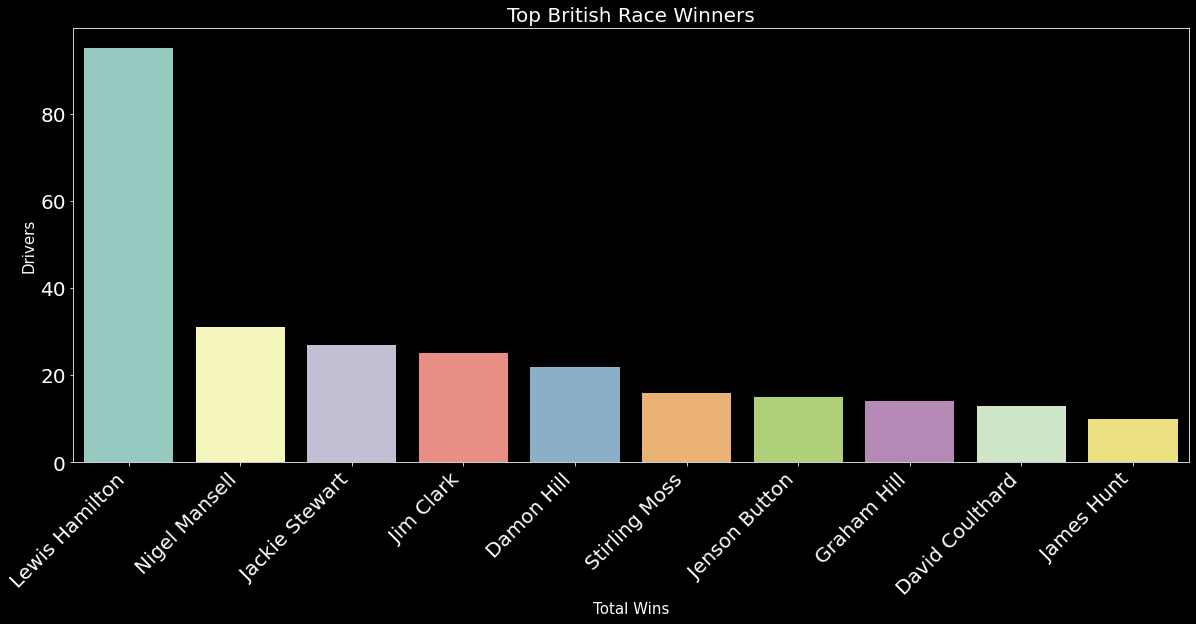

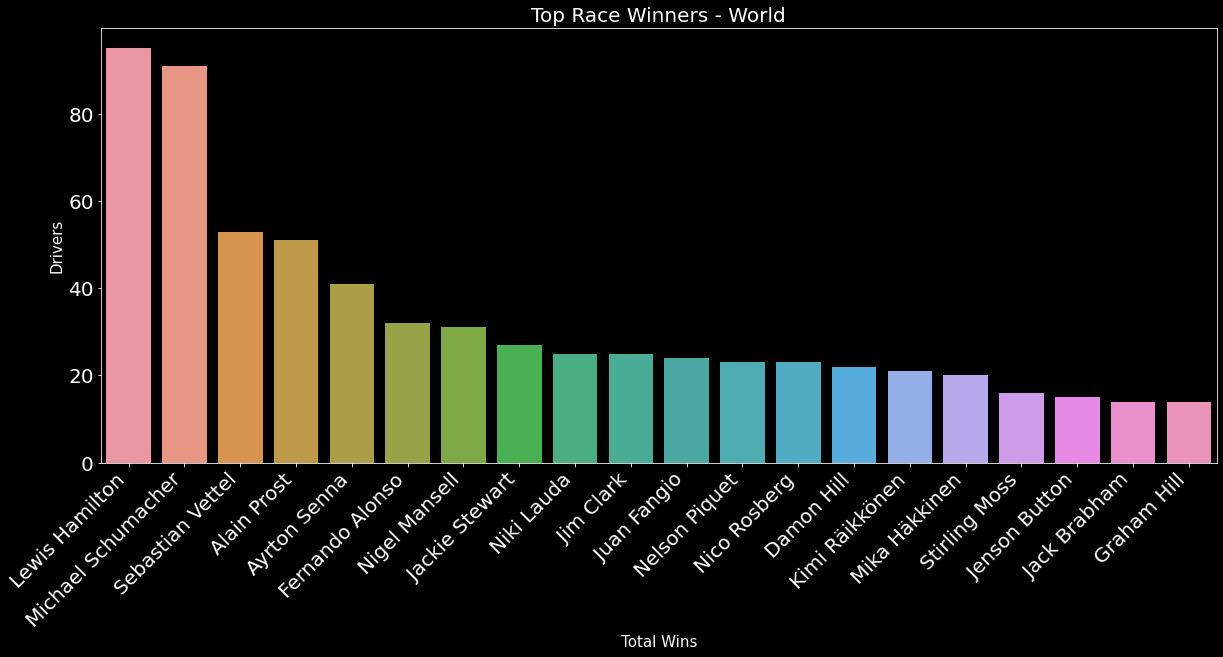

In [705]:
topBritish = data.loc[(data['driverNationality'] == 'British') & 
                                       (data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending=False)[:10]

topWorld = data.loc[(data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending=False)[:20]

fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(topBritish.index), list(topBritish.values))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Top British Race Winners", fontsize=20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(topWorld.index), list(topWorld.values))
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.xticks(rotation = 45, ha = 'right')
plt.title("Top Race Winners - World", fontsize = 20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.show()

Hamilton has surpassed Schumacher in the most number of wins.

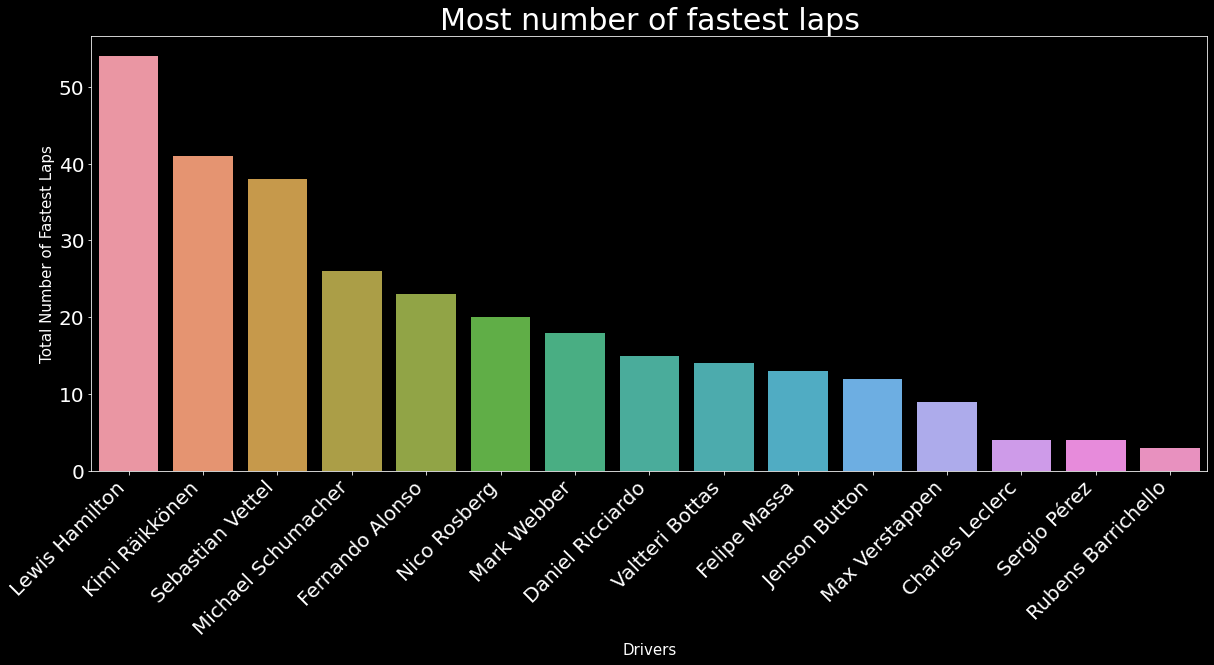

In [706]:
f_laps = data.copy()
f_laps = f_laps[['raceId', 'year', 'fullName', 'fastestLapTime']].sort_values(['year', 'raceId'])
f_laps = f_laps[f_laps['fastestLapTime'] != 0]
f_laps = f_laps.drop(['year'], axis = 1)

y = range(1, data.raceId.max()+1)
counts = pd.DataFrame()
for x in y:
    counts = counts.append(f_laps.loc[f_laps['raceId'] == x].sort_values(['fastestLapTime'])[:1])

counts = counts.groupby('fullName').count().sort_values(['fastestLapTime'], ascending = False)[:15]
counts
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(counts.index), counts['fastestLapTime'])
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.xticks(rotation = 45, ha = 'right')
plt.title("Most number of fastest laps", fontsize = 30)
plt.ylabel('Total Number of Fastest Laps', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

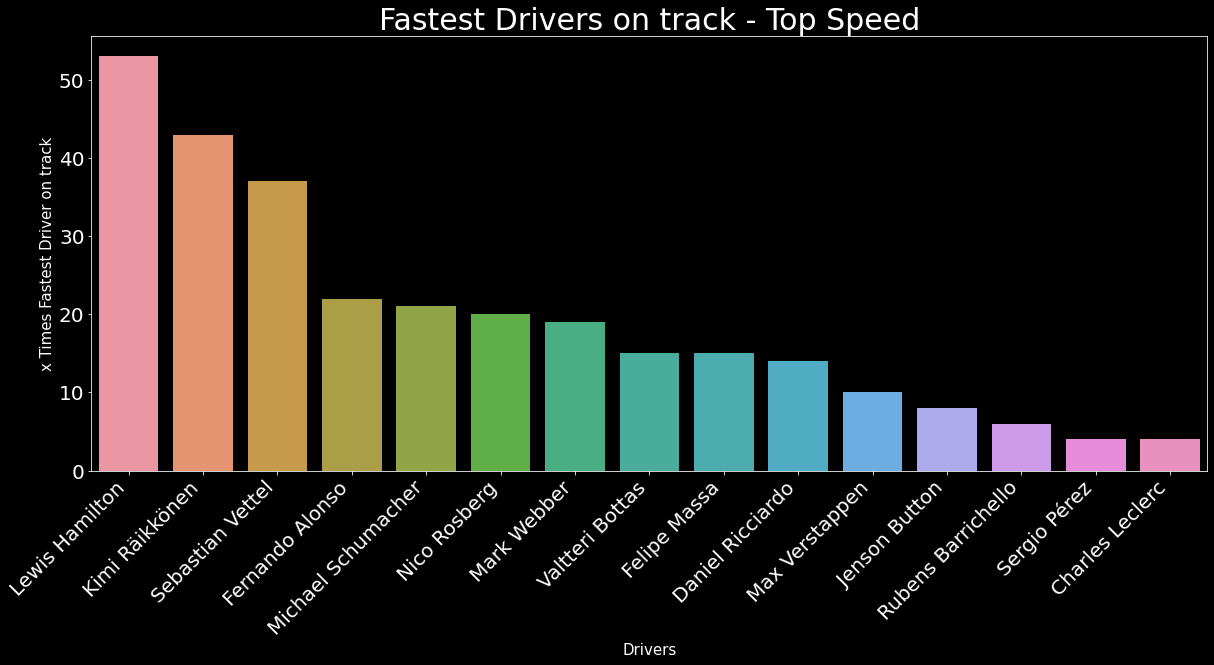

In [707]:
f_laps_speed = data.copy()
f_laps_speed = f_laps_speed[['raceId', 'year', 'fullName', 'fastestLapSpeed']].sort_values(['year', 'raceId'])
f_laps_speed = f_laps_speed[f_laps_speed['fastestLapSpeed'] != 0]
f_laps_speed = f_laps_speed.drop(['year'], axis = 1)

y = range(1, data.raceId.max()+1)
counts_speed = pd.DataFrame()
for x in y:
    counts_speed = counts_speed.append(f_laps_speed.loc[f_laps_speed['raceId'] == x].sort_values(['fastestLapSpeed'], ascending = False)[:1])

counts_speed = counts_speed.groupby('fullName').count().sort_values(['fastestLapSpeed'], ascending = False)[:15]
counts_speed
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 20)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(counts_speed.index), counts_speed['fastestLapSpeed'])
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.xticks(rotation = 45, ha = 'right')
plt.title("Fastest Drivers on track - Top Speed", fontsize = 30)
plt.ylabel('x Times Fastest Driver on track', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

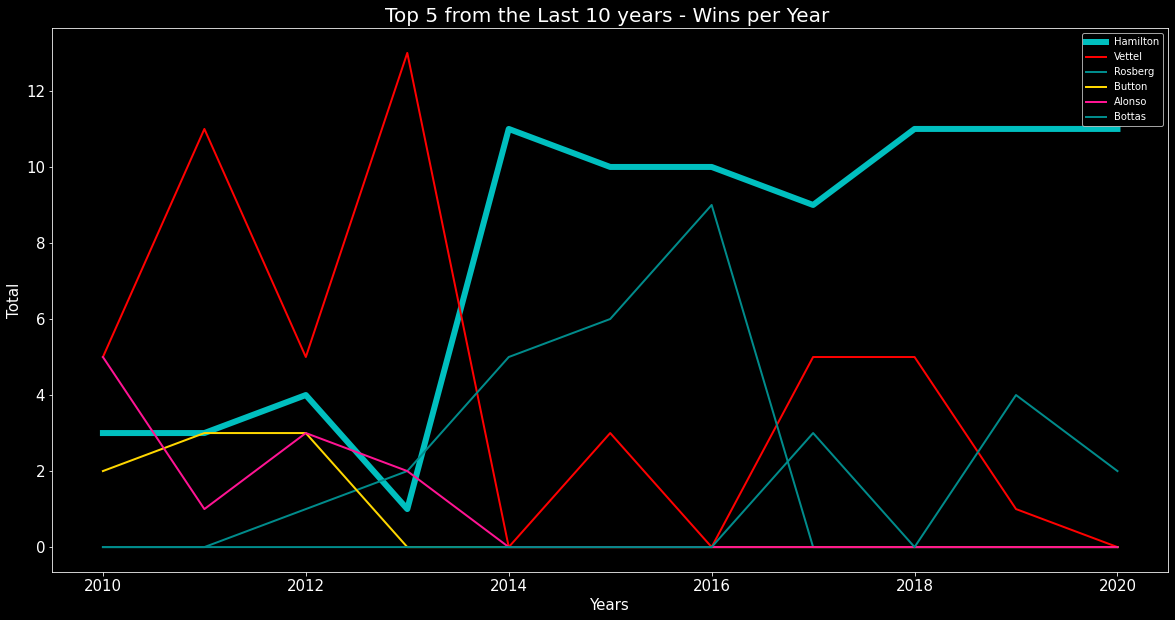

In [708]:
def wins_per_year(driverRef, year):
    try:
        return topTenYears.loc[(topTenYears['driverRef'] == driverRef) & (topTenYears['positionOrder'] == 1) & 
                               (topTenYears['year'] == year)].groupby('driverId')['raceId'].count().values[0]
    except:
        return 0

topTenYears = data.copy()
hamWinsPerYear = []
vetWinsPerYear = []
rosWinsPerYear = []
butWinsPerYear = []
aloWinsPerYear = []
botWinsPerYear = []

x = (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)

for year in x:
    hamWinsPerYear.append(wins_per_year('hamilton',year))
    vetWinsPerYear.append(wins_per_year('vettel',year))
    rosWinsPerYear.append(wins_per_year('rosberg',year))
    butWinsPerYear.append(wins_per_year('button',year))
    aloWinsPerYear.append(wins_per_year('alonso',year))
    botWinsPerYear.append(wins_per_year('bottas',year))

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

line1, = axs.plot(x, hamWinsPerYear, label = 'Hamilton', color='c', linewidth = 6,)
line2, = axs.plot(x, vetWinsPerYear, label = 'Vettel', color = 'r', linewidth = 2)
line3, = axs.plot(x, rosWinsPerYear, label = 'Rosberg', color = 'darkcyan', linewidth = 2)
line4, = axs.plot(x, butWinsPerYear, label = 'Button', color = 'gold', linewidth = 2)
line5, = axs.plot(x, aloWinsPerYear, label = 'Alonso', color = 'deeppink', linewidth = 2)
line5, = axs.plot(x, botWinsPerYear, label = 'Bottas', color = 'darkcyan', linewidth = 2)
plt.title("Top 5 from the Last 10 years - Wins per Year ", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Years', fontsize = 15)
axs.legend()
plt.show()

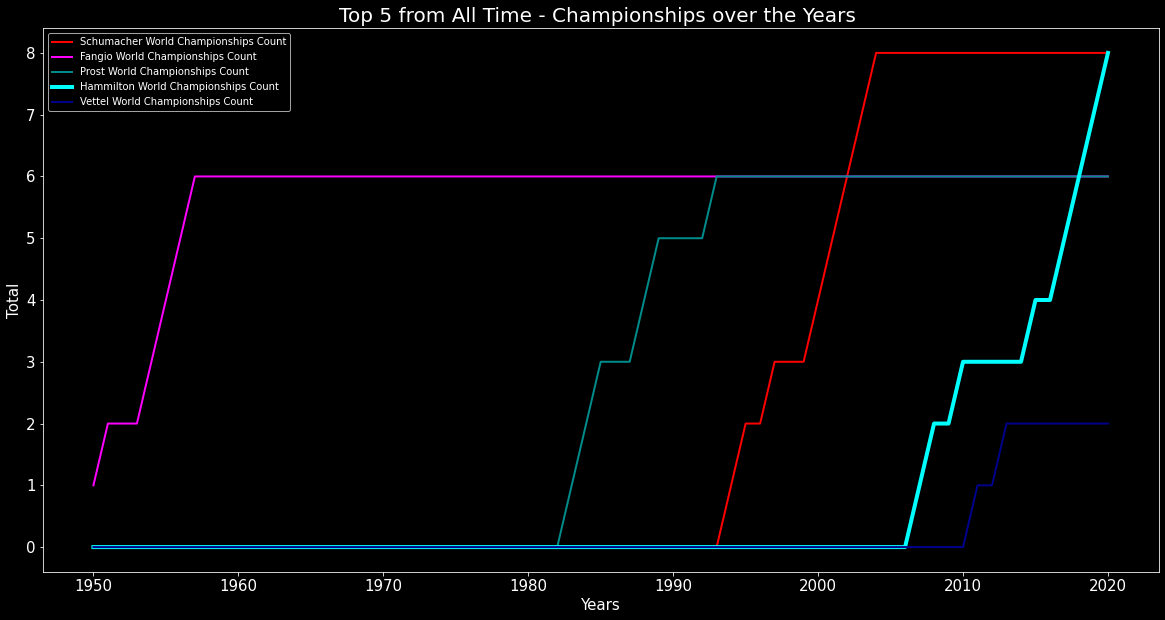

In [709]:
def championsInYears(years, driverRef):
    total = []
    t = 0
    for year in years:
        winner = topTenYears.loc[topTenYears['year'] == year].groupby('driverRef')['driverPoints'].sum().sort_values(ascending = False).index[0]
        if winner == driverRef:
            t = t + 1
        total.append(t)
    return total

schumiCP = championsInYears(np.sort(topTenYears['year'].unique()), 'michael_schumacher')
fangioCP = championsInYears(np.sort(topTenYears['year'].unique()), 'fangio')
prostCP = championsInYears(np.sort(topTenYears['year'].unique()), 'prost')
hamiltonCP = championsInYears(np.sort(topTenYears['year'].unique()), 'hamilton')
vettelCP = championsInYears(np.sort(topTenYears['year'].unique()), 'vettel')

x = range(1950, 2021)

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

line1, = axs.plot(x, schumiCP, label = 'Schumacher World Championships Count', color = 'r', linewidth = 2)
line2, = axs.plot(x, fangioCP, label = 'Fangio World Championships Count', color = 'magenta', linewidth = 2)
line3, = axs.plot(x, prostCP, label = 'Prost World Championships Count', color ='darkcyan', linewidth = 2)
line4, = axs.plot(x, hamiltonCP, label = 'Hammilton World Championships Count', color = 'aqua', linewidth = 4)
line5, = axs.plot(x, vettelCP, label = 'Vettel World Championships Count', color = 'darkblue', linewidth= 2)
plt.title("Top 5 from All Time - Championships over the Years ", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Years', fontsize = 15)
axs.legend()
plt.show()

#### Hamilton Rosberg Rivalry

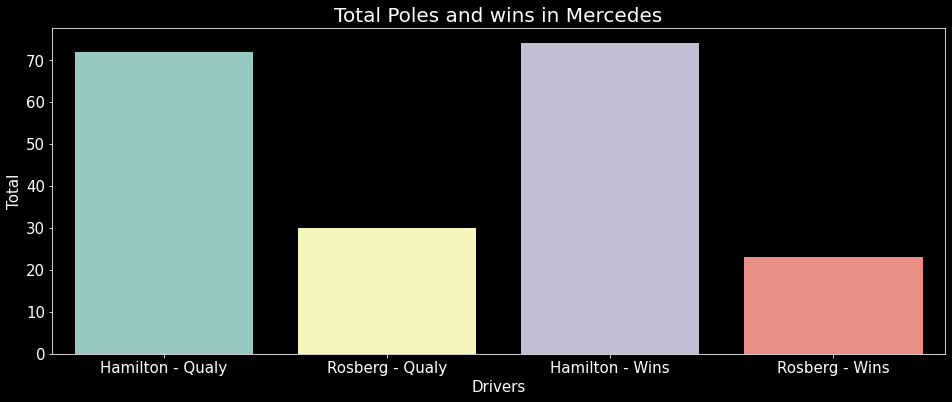

No handles with labels found to put in legend.


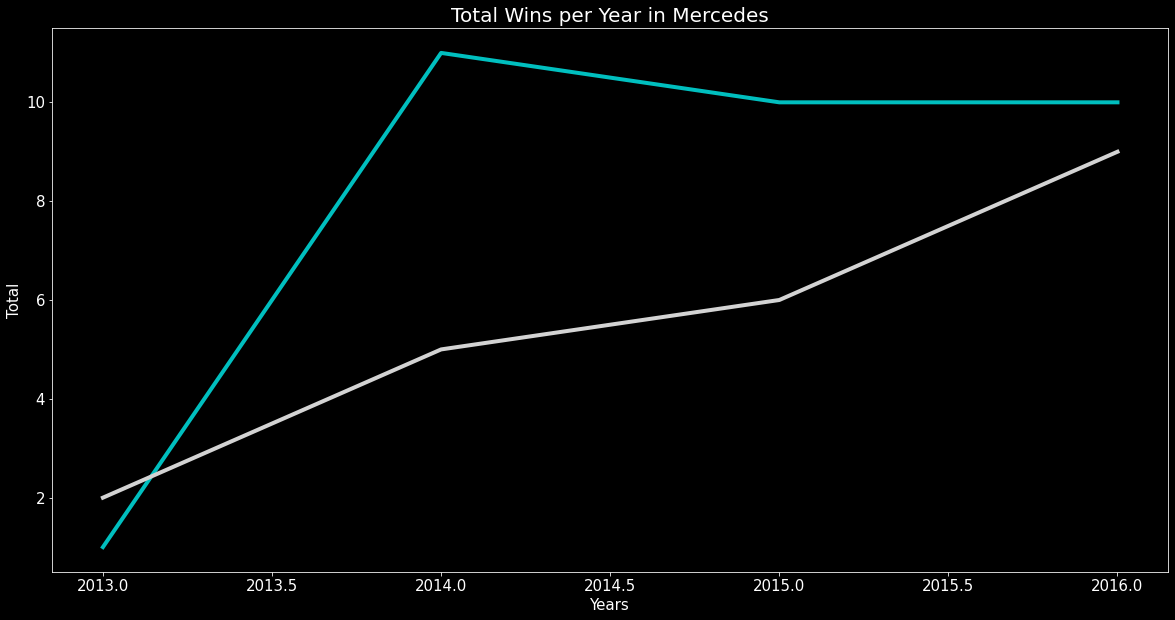

In [710]:
mercedesId = constructors.loc[(constructors['constructorRef'] == 'mercedes')]['constructorId'].values[0]
hamQtdQualy = len(qualifying.loc[(qualifying['driverId'] == 1) & (qualifying['position'] == 1) & (qualifying['constructorId'] == mercedesId)])
rosQtdQualy = len(qualifying.loc[(qualifying['driverId'] == 3 ) & (qualifying['position'] == 1) & (qualifying['constructorId'] == mercedesId)])
hamQtdRaces = len(results.loc[(results['positionOrder'] == 1) & (results['driverId'] == 1) & (results['constructorId'] == 131)])
rosQtdRaces = len(results.loc[(results['positionOrder'] == 1) & (results['driverId'] == 3) & (results['constructorId'] == 131)])
hamWinsPerYear = data.loc[(data['driverId']==1) & (data['constructorId'] == 131) &
                          (data['positionOrder'] == 1) & (data['year'] < 2017)].groupby('year')['driverId'].count()
rosWinsPerYear = data.loc[(data['driverId']==3) & (data['constructorId'] == 131) &
                          (data['positionOrder'] == 1) & (data['year'] > 2012)].groupby('year')['driverId'].count()

fig, axs = plt.subplots(figsize = (16, 6))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

sns.barplot(['Hamilton - Qualy', 'Rosberg - Qualy', 'Hamilton - Wins', 'Rosberg - Wins'], [hamQtdQualy, rosQtdQualy, hamQtdRaces, rosQtdRaces])
axs.set_facecolor('k')
plt.title("Total Poles and wins in Mercedes", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

x = list(hamWinsPerYear.index)
y = hamWinsPerYear
f,ax = plt.subplots(figsize = (20, 10))
ax.tick_params(axis="x", labelsize = 15)
ax.tick_params(axis="y", labelsize = 15)

ax.set_facecolor('k')
line1, = ax.plot(x, hamWinsPerYear.values, label = 'Hamilton Wins', color = 'c', linewidth = 4)
line2, = ax.plot(x, rosWinsPerYear.values, label = 'Rosberg Wins' ,linewidth = 4, color = 'lightgray')
plt.title("Total Wins per Year in Mercedes", fontsize = 20)
plt.ylabel('Total', fontsize = 15)
plt.xlabel('Years', fontsize = 15)
axs.legend()
plt.show()

#### Iconic races for Hamilton

Suzuka GP 2015 

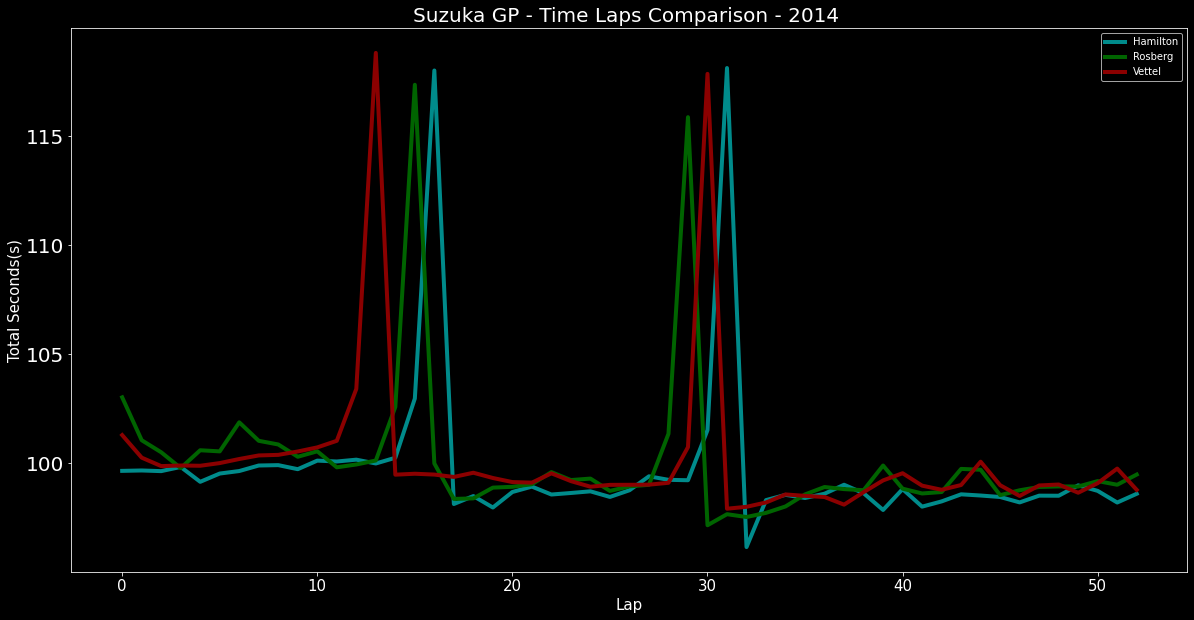

In [711]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 940))]['time'].iloc[:].values
timeRos = lap_times.loc[(lap_times['driverId'] == 3) & (lap_times['raceId'] == 940)]['time'].iloc[:].values
timeVet = lap_times.loc[(lap_times['driverId'] == 20) & (lap_times['raceId'] == 940)]['time'].iloc[:].values

x = range(0, 53)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label= 'Hamilton', color = 'darkcyan', linewidth = 4)
line2, = axs.plot(x, timeRos, label = 'Rosberg', color = 'darkgreen' , linewidth = 4)
line2, = axs.plot(x, timeVet, label = 'Vettel', color = 'darkred' , linewidth = 4)
plt.title("Suzuka GP - Time Laps Comparison - 2014 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.show()

Monza GP 2011

Biggest battle between Hamilton and the 7 time world champ Schumacher

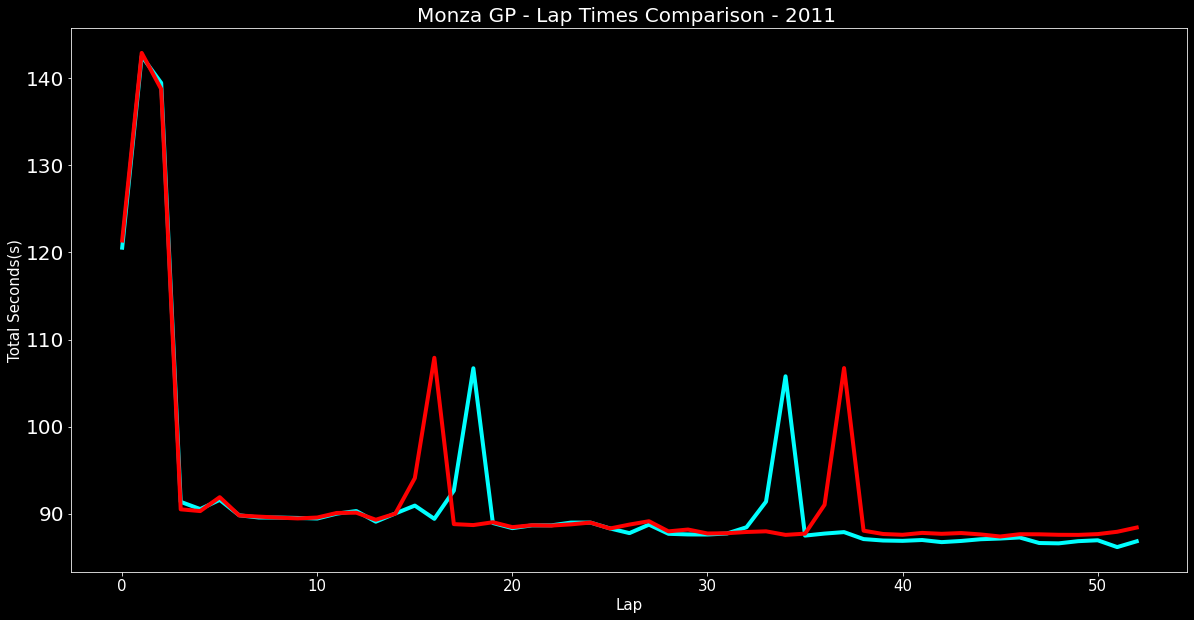

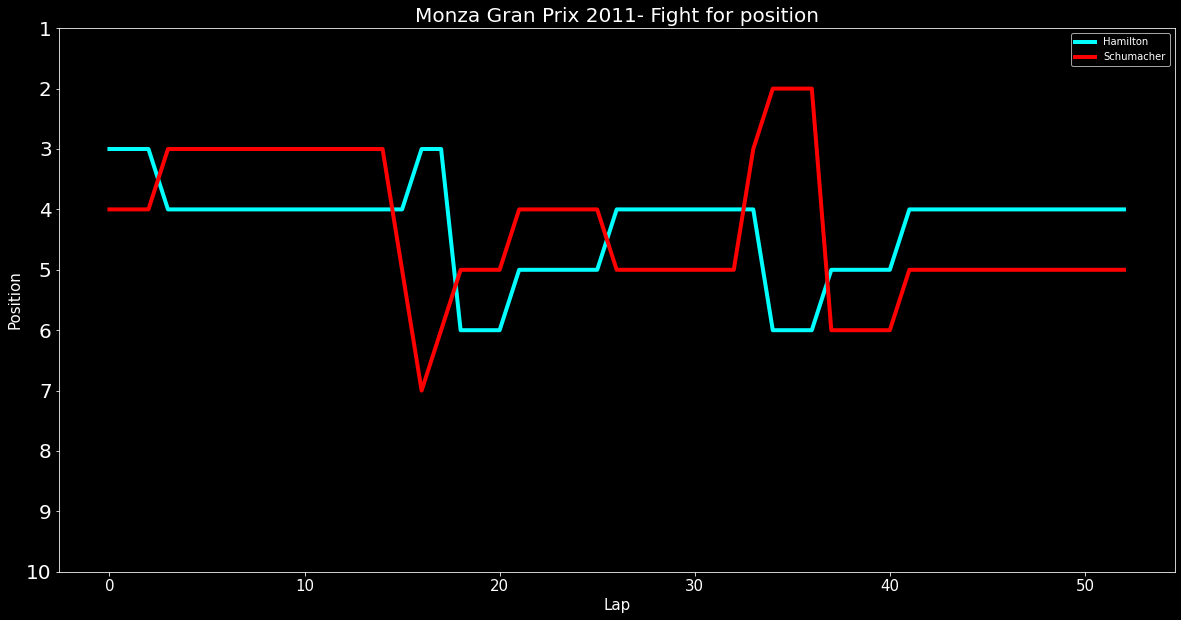

In [712]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 853))]['time'].iloc[:].values
timeSchumi = lap_times.loc[(lap_times['driverId'] == 30) & (lap_times['raceId'] == 853)]['time'].iloc[:].values
x = range(0, 53)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label = 'Hamilton', color = 'cyan', linewidth = 4)
line2, = axs.plot(x, timeSchumi, label = 'Schumacher' , color = 'red', linewidth = 4)
plt.title("Monza GP - Lap Times Comparison - 2011 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
ax.legend()
plt.show()

positionsHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 853))]['position'].iloc[:].values
positionsSchumi = lap_times.loc[(lap_times['driverId'] == 30) & (lap_times['raceId'] == 853)]['position'].iloc[:].values

x = range(0, 53)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, positionsHamilton, label = 'Hamilton', color = 'cyan', linewidth = 4,)
line2, = axs.plot(x, positionsSchumi, label = 'Schumacher', color = 'red' , linewidth = 4,)
plt.title("Monza Gran Prix 2011- Fight for position", fontsize = 20)
plt.ylabel('Position', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.ylim(10, 1)
plt.show()

British GP - 2020

Hamilton's last lap = Lightning McQueen

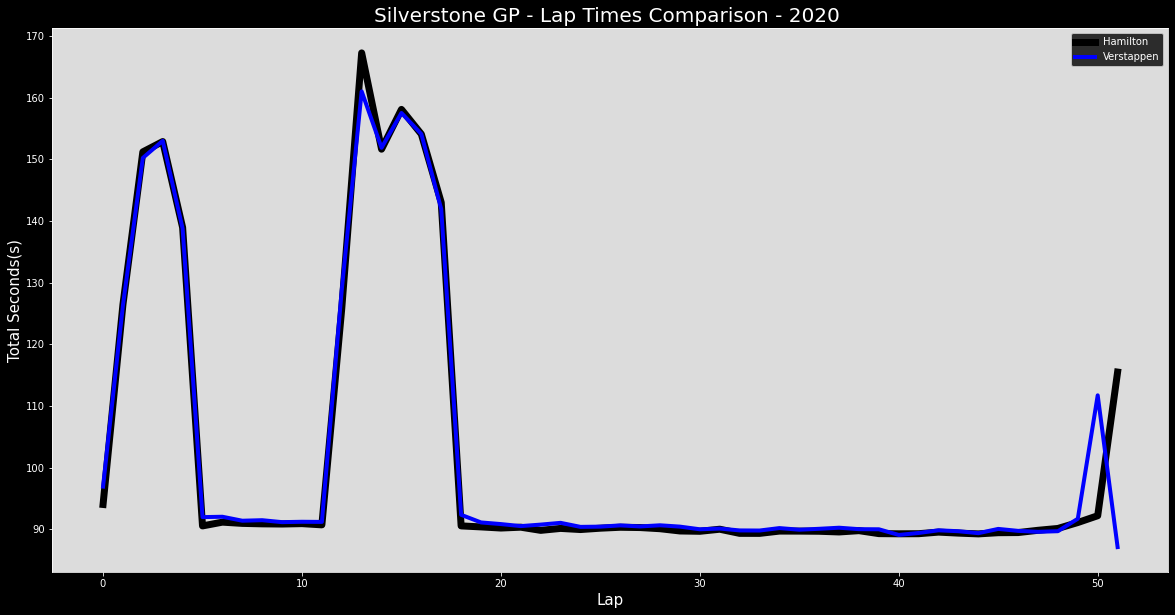

In [713]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 1034))]['time'].iloc[:].values
timeVerst = lap_times.loc[(lap_times['driverId'] == 830) & (lap_times['raceId'] == 1034)]['time'].iloc[:].values
x = range(0, 52)
fig, axs = plt.subplots(figsize = (20, 10))
ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('whitesmoke')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label = 'Hamilton', color = 'k', linewidth = 7)
line2, = axs.plot(x, timeVerst, label = 'Verstappen', color = 'blue', linewidth = 4)
plt.title("Silverstone GP - Lap Times Comparison - 2020 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 15)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.show()

Turkish GP - 2020

Hamiltons's 7th Title winning race

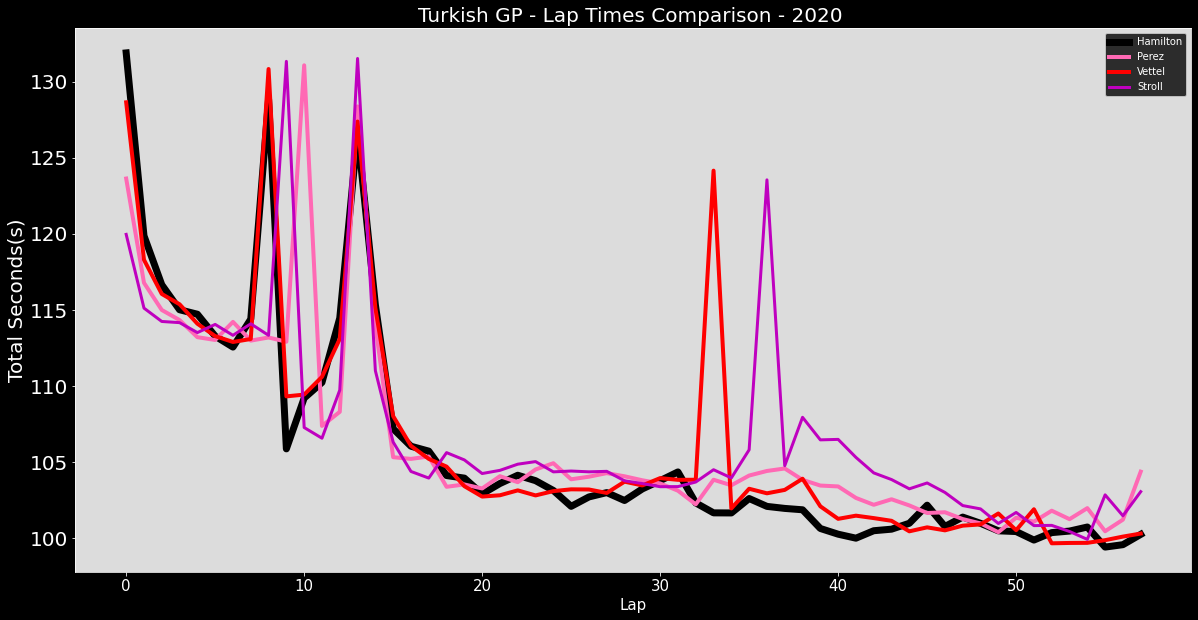

In [714]:
timeHamilton = lap_times.loc[((lap_times['driverId'] == 1) & (lap_times['raceId'] == 1044))]['time'].iloc[:].values
timePerez = lap_times.loc[(lap_times['driverId'] == 815) & (lap_times['raceId'] == 1044)]['time'].iloc[:].values
timeVet = lap_times.loc[(lap_times['driverId'] == 20) & (lap_times['raceId'] == 1044)]['time'].iloc[:].values

timeStroll = lap_times.loc[(lap_times['driverId'] == 840) & (lap_times['raceId'] == 1044)]['time'].iloc[:].values


x = range(0, 58)
fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

axs.set_facecolor('whitesmoke')
axs.patch.set_alpha(0.9)
line1, = axs.plot(x, timeHamilton, label = 'Hamilton', color = 'k', linewidth = 7)
line2, = axs.plot(x, timePerez, label = 'Perez' , color = 'hotpink', linewidth = 4)
line3, = axs.plot(x, timeVet, label = 'Vettel' , color = 'Red', linewidth = 4)
line4, = axs.plot(x, timeStroll, label = 'Stroll' , color = 'm', linewidth = 3)

plt.title("Turkish GP - Lap Times Comparison - 2020 ", fontsize = 20)
plt.ylabel('Total Seconds(s)', fontsize = 20)
plt.xlabel('Lap', fontsize = 15)
axs.legend()
plt.show()

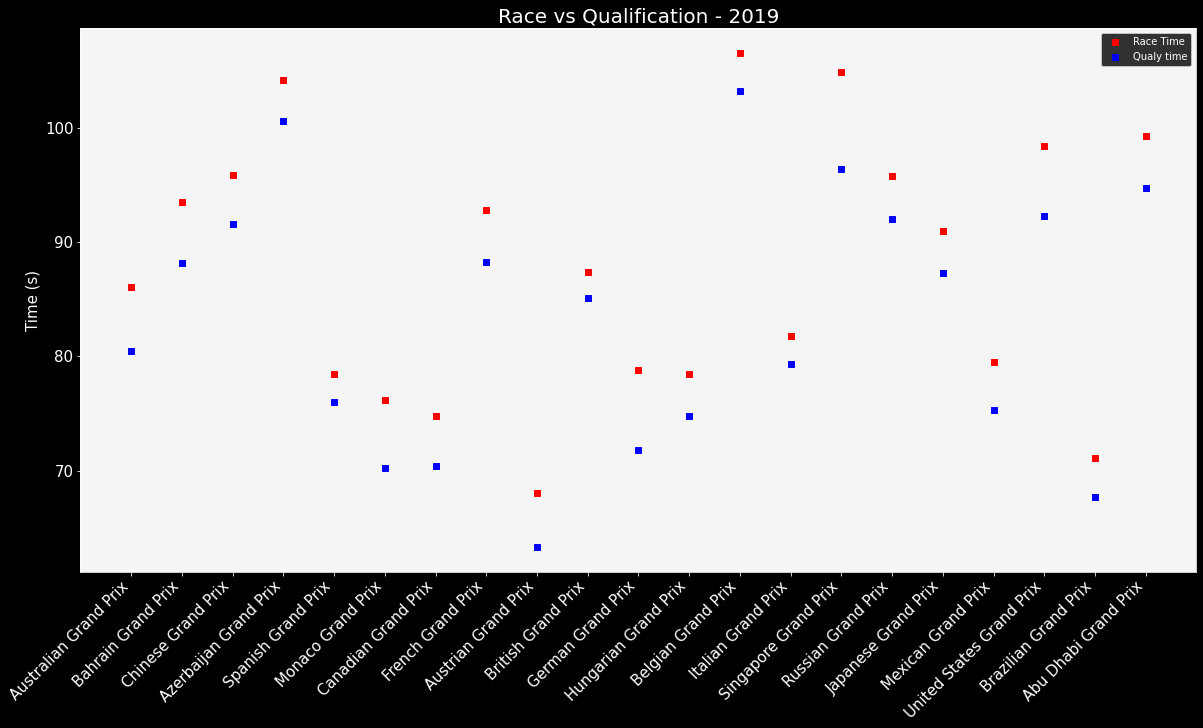

In [715]:
racesQualysHam = data_10.loc[(data_10['driverRef'] == 'hamilton') & (data_10['year'] == 2019) & (data_10['q3'] != 0)]

qualTimes = racesQualysHam['q3'].values
raceTimes = racesQualysHam['fastestLapTime'].values
x = racesQualysHam.GrandPrix.values

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

axs.set_facecolor('whitesmoke')
line1, = axs.plot(x, raceTimes, 'bs', c = 'red',label = "Race Time")
line2, = axs.plot(x, qualTimes,'bs', c = 'blue', label = "Qualy time")
plt.title("Race vs Qualification - 2019", fontsize = 20)
plt.ylabel('Time (s)', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
axs.legend()
plt.show()

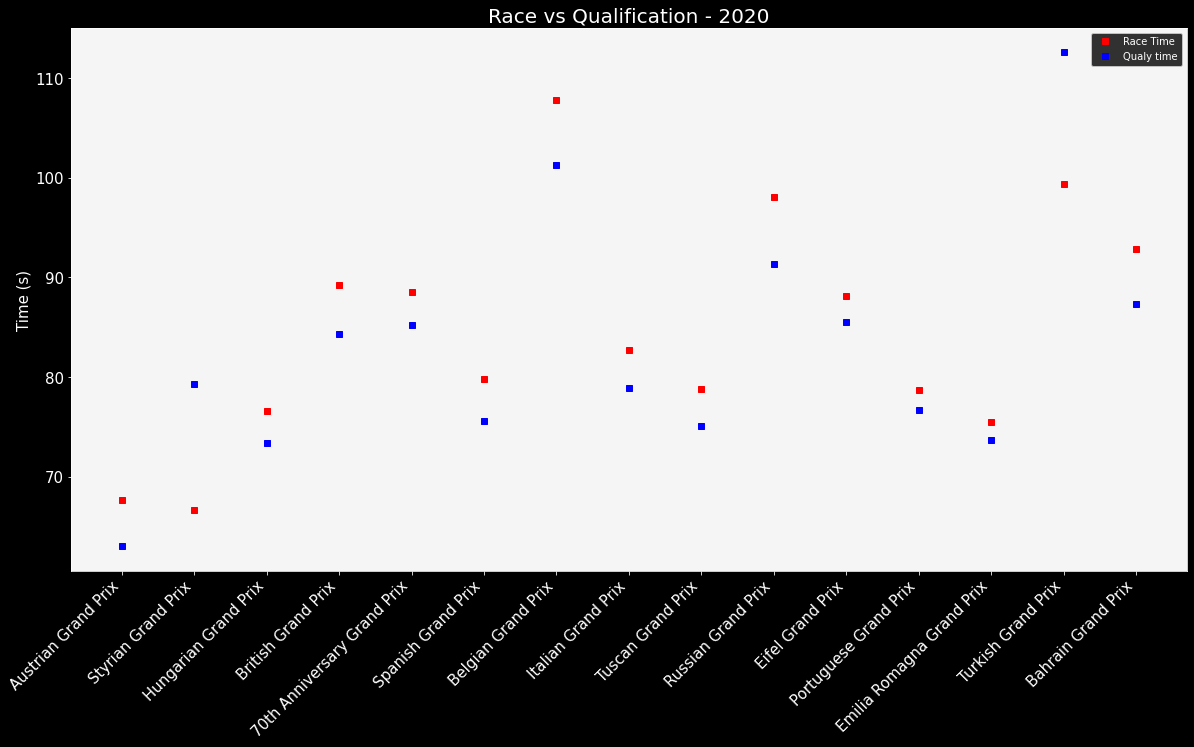

In [716]:
racesQualysHam = data_10.loc[(data_10['driverRef'] == 'hamilton') & (data_10['year'] == 2020) & (data_10['q3'] != 0)]

qualTimes = racesQualysHam['q3'].values
raceTimes = racesQualysHam['fastestLapTime'].values
x = racesQualysHam.GrandPrix.values

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)

axs.set_facecolor('whitesmoke')
line1, = axs.plot(x, raceTimes, 'bs', c = 'red',label = "Race Time")
line2, = axs.plot(x, qualTimes,'bs', c = 'blue', label = "Qualy time")
plt.title("Race vs Qualification - 2020", fontsize = 20)
plt.ylabel('Time (s)', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
axs.legend()
plt.show()

In [717]:
winsHam = data.loc[(data['driverRef']=='hamilton')]['grid'].value_counts()

trace = go.Pie(labels = winsHam.index, values = winsHam.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Hamilton - Percentage of entered races vs race wins', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

winsSenna = data.loc[(data['driverRef']=='senna')]['grid'].value_counts()

trace = go.Pie(labels = winsSenna.index, values = winsSenna.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Senna - Percentage of entered races vs race wins', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

winsSchumi = data.loc[(data['driverRef']=='michael_schumacher')]['grid'].value_counts()

trace = go.Pie(labels = winsSchumi.index, values = winsSchumi.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Schumacher - Percentage of entered races vs race wins', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

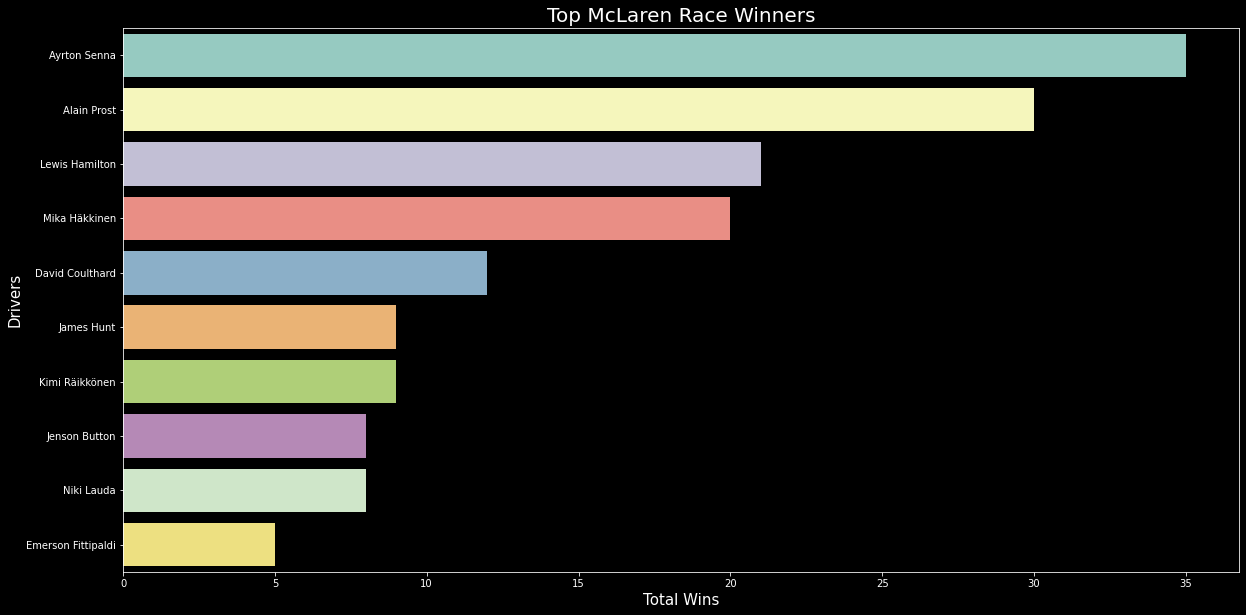

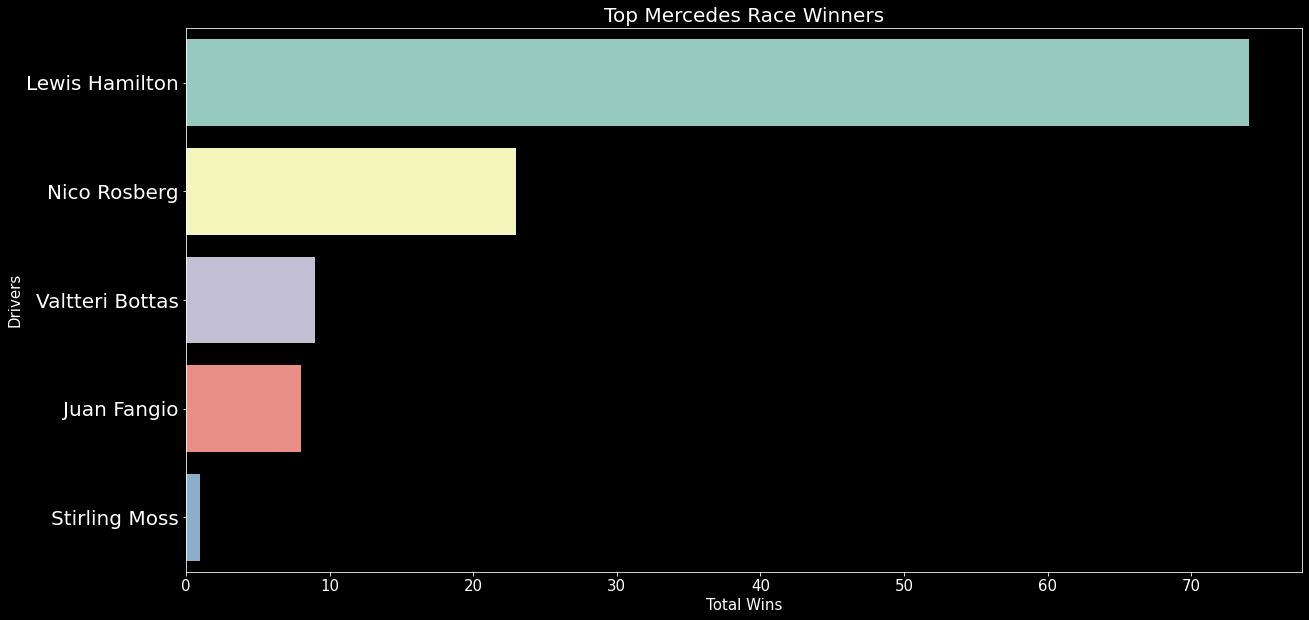

In [718]:
mclarensRacers = data.loc[(data['constructorId'] == 1) &
                                 (data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending = False)[:10]

mercedesRacers = data.loc[(data['constructorId'] == 131) &
                                 (data['positionOrder'] == 1)].groupby('fullName')['raceId'].count().sort_values(ascending = False)[:10]

fig, axs = plt.subplots(figsize = (20, 10))
ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(mclarensRacers.values), list(mclarensRacers.index))
sns.color_palette("hls", 8)
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Top McLaren Race Winners", fontsize = 20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.show()

fig, axs = plt.subplots(figsize = (20, 10))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)

sns.barplot(list(mercedesRacers.values), list(mercedesRacers.index))
sns.color_palette("hls", 8)
axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
plt.title("Top Mercedes Race Winners", fontsize = 20)
plt.ylabel('Drivers', fontsize = 15)
plt.xlabel('Total Wins', fontsize = 15)
plt.show()

# Race Stats Comparison between 2019 and 2020 season

In [719]:
data_19 = data[data['year'] == 2019]
data_20 = data[data['year'] == 2020]

In [720]:
driver_age = data_19.drop_duplicates(subset = ["driverId"])
age_count = driver_age['age'].value_counts()

trace = go.Pie(labels = age_count.index, values = age_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Age distribution across the grid - 2019', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

In [721]:
driver_age = data_20.drop_duplicates(subset = ["driverId"])
age_count = driver_age['age'].value_counts()

trace = go.Pie(labels = age_count.index, values = age_count.values, hole = 0.6,textinfo = "none")
layout = go.Layout(title = 'Age distribution across the grid - 2020', paper_bgcolor = 'gainsboro')
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(margin = dict(l = 60, r = 60, t = 50, b = 50))
iplot(fig, filename = "plotting-library")

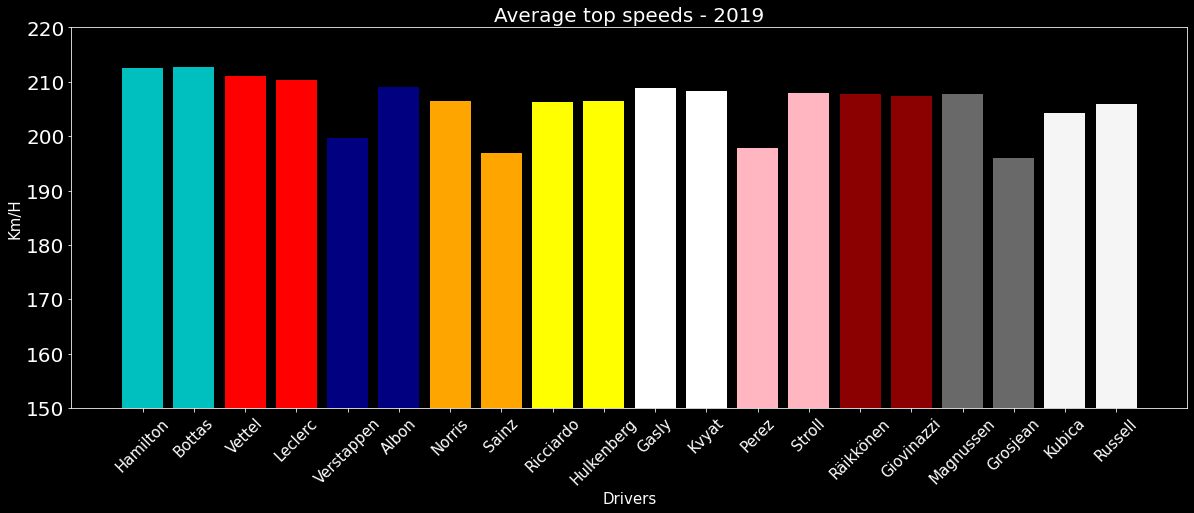

In [722]:
speedHam = (data_19.loc[((data_19['driverId'] == 1))]['fastestLapSpeed'].iloc[:].values.mean())
speedBot = (data_19.loc[((data_19['driverId'] == 822))]['fastestLapSpeed'].iloc[:].values.mean())
speedVet = (data_19.loc[((data_19['driverId'] == 20))]['fastestLapSpeed'].iloc[:].values.mean())
speedLec = (data_19.loc[((data_19['driverId'] == 844))]['fastestLapSpeed'].iloc[:].values.mean())
speedVer = (data_19.loc[((data_19['driverId'] == 830))]['fastestLapSpeed'].iloc[:].values.mean())
speedAlb = (data_19.loc[((data_19['driverId'] == 848))]['fastestLapSpeed'].iloc[:].values.mean())
speedNor = (data_19.loc[((data_19['driverId'] == 846))]['fastestLapSpeed'].iloc[:].values.mean())
speedSai = (data_19.loc[((data_19['driverId'] == 832))]['fastestLapSpeed'].iloc[:].values.mean())
speedRic = (data_19.loc[((data_19['driverId'] == 817))]['fastestLapSpeed'].iloc[:].values.mean())
speedHul = (data_19.loc[((data_19['driverId'] == 807))]['fastestLapSpeed'].iloc[:].values.mean())
speedGas = (data_19.loc[((data_19['driverId'] == 842))]['fastestLapSpeed'].iloc[:].values.mean())
speedKyv = (data_19.loc[((data_19['driverId'] == 826))]['fastestLapSpeed'].iloc[:].values.mean())
speedPerez = (data_19.loc[((data_19['driverId'] == 815))]['fastestLapSpeed'].iloc[:].values.mean())
speedStr = (data_19.loc[((data_19['driverId'] == 840))]['fastestLapSpeed'].iloc[:].values.mean())
speedRai = (data_19.loc[((data_19['driverId'] == 8))]['fastestLapSpeed'].iloc[:].values.mean())
speedGio = (data_19.loc[((data_19['driverId'] == 841))]['fastestLapSpeed'].iloc[:].values.mean())
speedMag = (data_19.loc[((data_19['driverId'] == 825))]['fastestLapSpeed'].iloc[:].values.mean())
speedGro = (data_19.loc[((data_19['driverId'] == 154))]['fastestLapSpeed'].iloc[:].values.mean())
speedKub = (data_19.loc[((data_19['driverId'] == 9))]['fastestLapSpeed'].iloc[:].values.mean())
speedRus = (data_19.loc[((data_19['driverId'] == 847))]['fastestLapSpeed'].iloc[:].values.mean())

fig, axs = plt.subplots(figsize = (20, 7))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)
plt.xticks(rotation = 45)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.bar('Hamilton', speedHam, color = 'c')
line2, = axs.bar('Bottas', speedBot, color = 'c')
line3, = axs.bar('Vettel', speedVet, color = 'r')
line4, = axs.bar('Leclerc', speedLec, color = 'r')
line5, = axs.bar('Verstappen', speedVer, color = 'navy')
line6, = axs.bar('Albon', speedAlb, color = 'navy')
line7, = axs.bar('Norris', speedNor, color = 'orange')
line8, = axs.bar('Sainz', speedSai, color = 'orange')
line9, = axs.bar('Ricciardo', speedRic, color = 'yellow')
line10, = axs.bar('Hulkenberg', speedHul, color = 'yellow')
line11, = axs.bar('Gasly', speedGas, color = 'white')
line12, = axs.bar('Kvyat', speedKyv, color = 'white')
line13, = axs.bar('Perez', speedPerez, color = 'lightpink')
line14, = axs.bar('Stroll', speedStr, color = 'lightpink')
line15, = axs.bar('Räikkönen', speedRai, color = 'darkred')
line16, = axs.bar('Giovinazzi', speedGio, color = 'darkred')
line17, = axs.bar('Magnussen', speedMag, color = 'dimgrey')
line18, = axs.bar('Grosjean', speedGro, color = 'dimgrey')
line19, = axs.bar('Kubica', speedKub, color = 'whitesmoke')
line20, = axs.bar('Russell', speedRus, color = 'whitesmoke')

plt.ylim(150, 220)
plt.title("Average top speeds - 2019", fontsize = 20)
plt.ylabel('Km/H', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

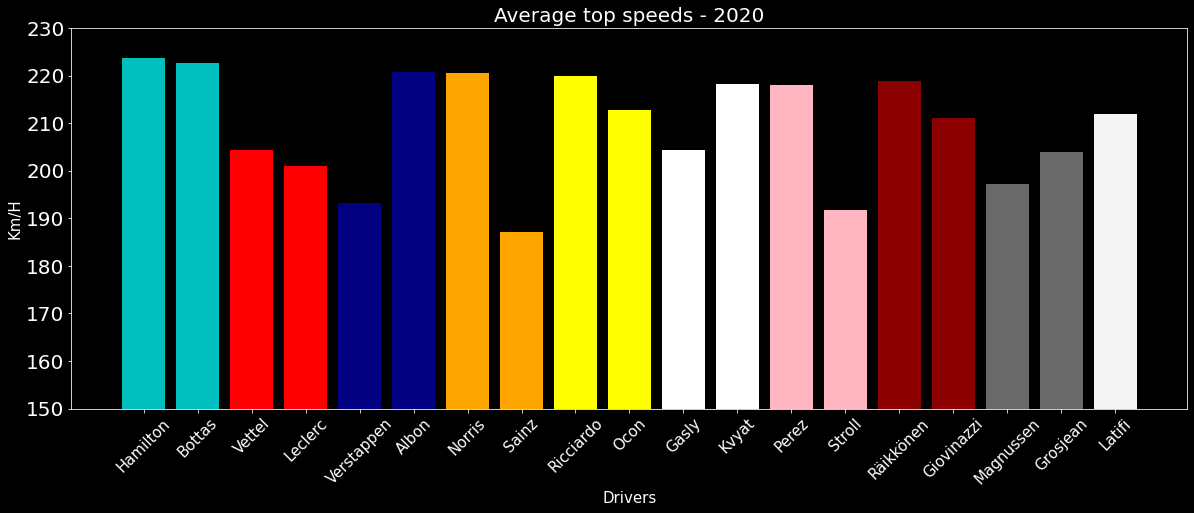

In [723]:
speedHam2 = (data_20.loc[((data_20['driverId'] == 1))]['fastestLapSpeed'].iloc[:].values.mean())
speedBot2 = (data_20.loc[((data_20['driverId'] == 822))]['fastestLapSpeed'].iloc[:].values.mean())
speedVet2 = (data_20.loc[((data_20['driverId'] == 20))]['fastestLapSpeed'].iloc[:].values.mean())
speedLec2 = (data_20.loc[((data_20['driverId'] == 844))]['fastestLapSpeed'].iloc[:].values.mean())
speedVer2 = (data_20.loc[((data_20['driverId'] == 830))]['fastestLapSpeed'].iloc[:].values.mean())
speedAlb2 = (data_20.loc[((data_20['driverId'] == 848))]['fastestLapSpeed'].iloc[:].values.mean())
speedNor2 = (data_20.loc[((data_20['driverId'] == 846))]['fastestLapSpeed'].iloc[:].values.mean())
speedSai2 = (data_20.loc[((data_20['driverId'] == 832))]['fastestLapSpeed'].iloc[:].values.mean())
speedRic2 = (data_20.loc[((data_20['driverId'] == 817))]['fastestLapSpeed'].iloc[:].values.mean())
speedOco = (data_20.loc[((data_20['driverId'] == 839))]['fastestLapSpeed'].iloc[:].values.mean())
speedGas2 = (data_20.loc[((data_20['driverId'] == 842))]['fastestLapSpeed'].iloc[:].values.mean())
speedKyv2 = (data_20.loc[((data_20['driverId'] == 826))]['fastestLapSpeed'].iloc[:].values.mean())
speedPerez2 = (data_20.loc[((data_20['driverId'] == 815))]['fastestLapSpeed'].iloc[:].values.mean())
speedStr2 = (data_20.loc[((data_20['driverId'] == 840))]['fastestLapSpeed'].iloc[:].values.mean())
speedRai2 = (data_20.loc[((data_20['driverId'] == 8))]['fastestLapSpeed'].iloc[:].values.mean())
speedGio2 = (data_20.loc[((data_20['driverId'] == 841))]['fastestLapSpeed'].iloc[:].values.mean())
speedMag2 = (data_20.loc[((data_20['driverId'] == 825))]['fastestLapSpeed'].iloc[:].values.mean())
speedGro2 = (data_20.loc[((data_20['driverId'] == 154))]['fastestLapSpeed'].iloc[:].values.mean())
speedLat = (data_20.loc[((data_20['driverId'] == 849))]['fastestLapSpeed'].iloc[:].values.mean())
speedRus2 = (data_20.loc[((data_20['driverId'] == 847))]['fastestLapSpeed'].iloc[:].values.mean())

fig, axs = plt.subplots(figsize = (20, 7))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 20)
plt.xticks(rotation = 45)

axs.set_facecolor('k')
axs.patch.set_alpha(0.9)
line1, = axs.bar('Hamilton', speedHam2, color = 'c')
line2, = axs.bar('Bottas', speedBot2, color = 'c')
line3, = axs.bar('Vettel', speedVet2, color = 'r')
line4, = axs.bar('Leclerc', speedLec2, color = 'r')
line5, = axs.bar('Verstappen', speedVer2, color = 'navy')
line6, = axs.bar('Albon', speedAlb2, color = 'navy')
line7, = axs.bar('Norris', speedNor2, color = 'orange')
line8, = axs.bar('Sainz', speedSai2, color = 'orange')
line9, = axs.bar('Ricciardo', speedRic2, color = 'yellow')
line10, = axs.bar('Ocon', speedOco, color = 'yellow')
line11, = axs.bar('Gasly', speedGas2, color = 'white')
line12, = axs.bar('Kvyat', speedKyv2, color = 'white')
line13, = axs.bar('Perez', speedPerez2, color = 'lightpink')
line14, = axs.bar('Stroll', speedStr2, color = 'lightpink')
line15, = axs.bar('Räikkönen', speedRai2, color = 'darkred')
line16, = axs.bar('Giovinazzi', speedGio2, color = 'darkred')
line17, = axs.bar('Magnussen', speedMag2, color = 'dimgrey')
line18, = axs.bar('Grosjean', speedGro2, color = 'dimgrey')
line19, = axs.bar('Latifi', speedLat, color = 'whitesmoke')
line20, = ax.bar('Russell', speedRus2, color = 'whitesmoke')

plt.ylim(150, 230)
plt.title("Average top speeds - 2020", fontsize = 20)
plt.ylabel('Km/H', fontsize = 15)
plt.xlabel('Drivers', fontsize = 15)
plt.show()

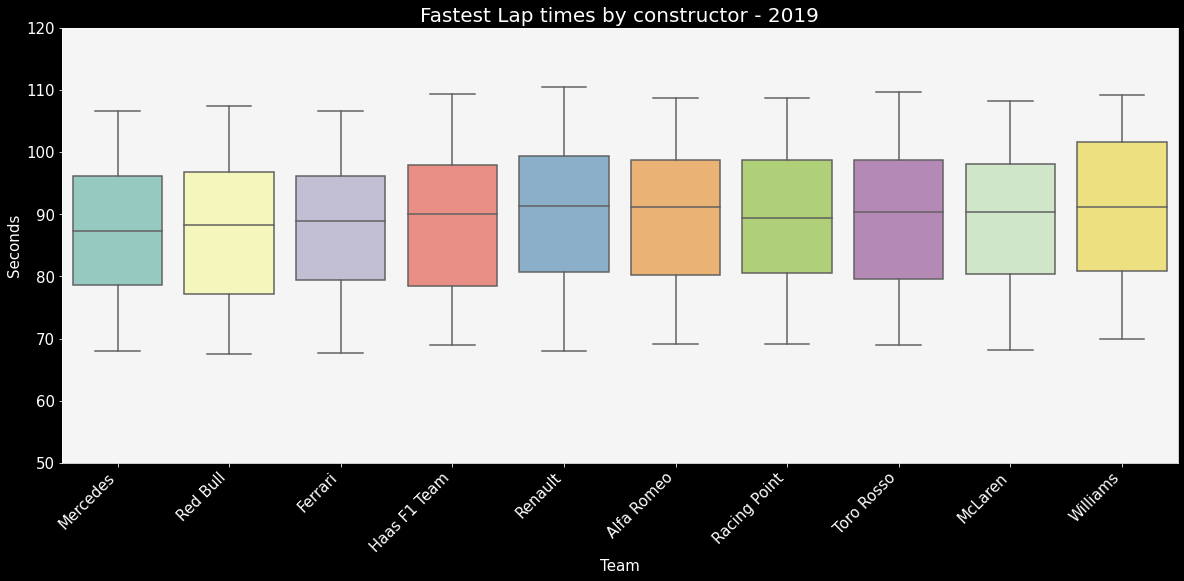

In [724]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapTime', data = data_19)
plt.ylim(50, 120)
plt.title("Fastest Lap times by constructor - 2019",fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

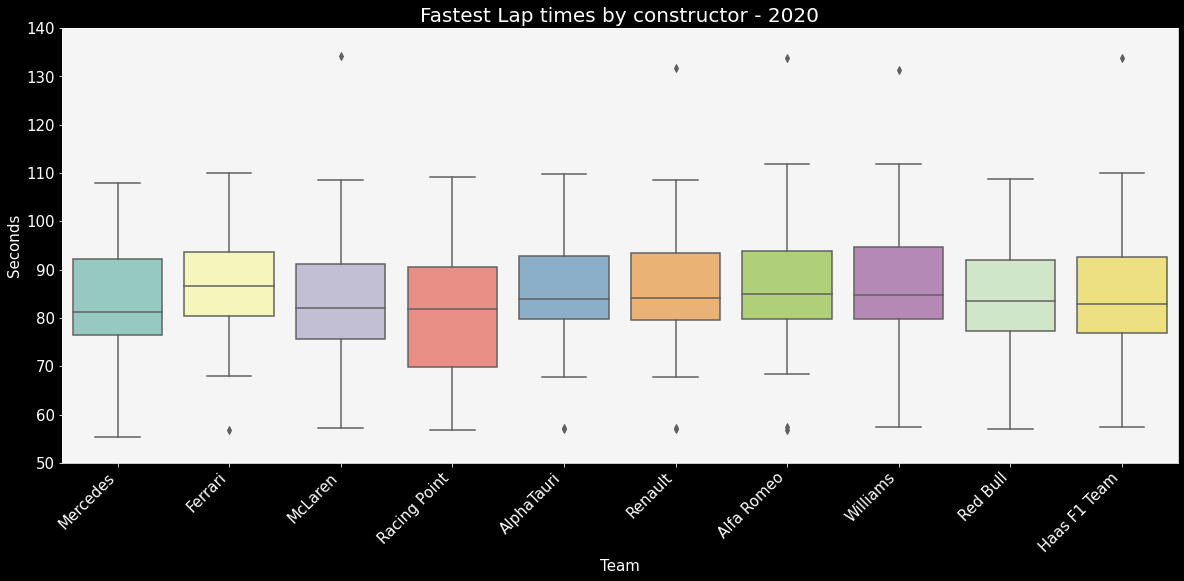

In [725]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapTime', data = data_20)
plt.ylim(50, 140)
plt.title("Fastest Lap times by constructor - 2020", fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('Seconds', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

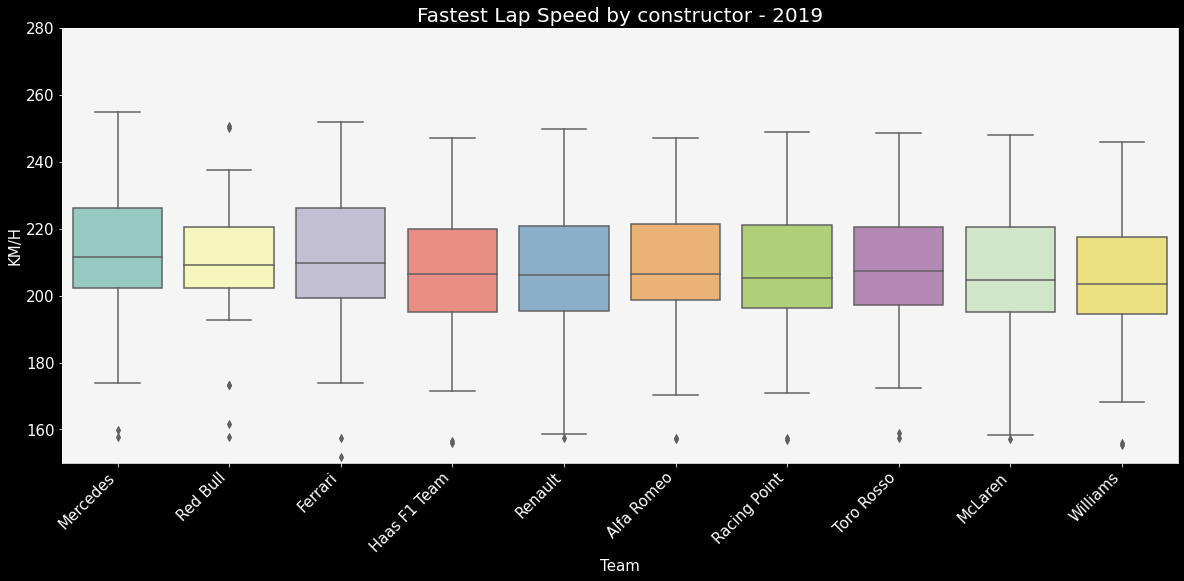

In [726]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapSpeed', data = data_19)
plt.ylim(150, 280)
plt.title("Fastest Lap Speed by constructor - 2019",fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('KM/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

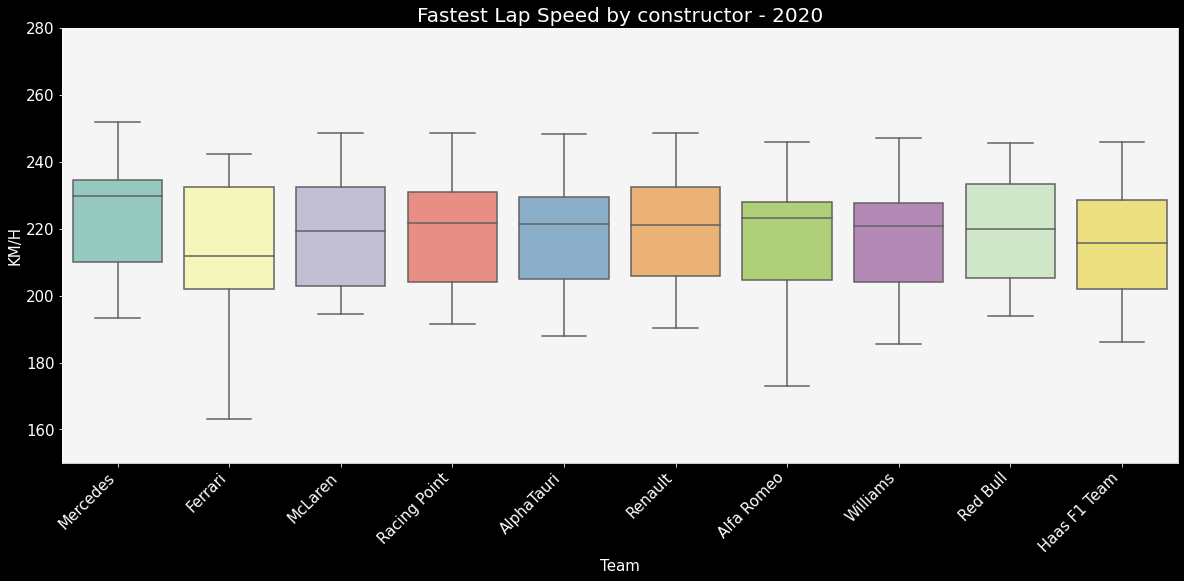

In [727]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.boxplot(x = 'constructor', y = 'fastestLapSpeed', data = data_20)
plt.ylim(150, 280)
plt.title("Fastest Lap Speed by constructor - 2020", fontsize = 20)
plt.xlabel('Team', fontsize = 15)
plt.ylabel('KM/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

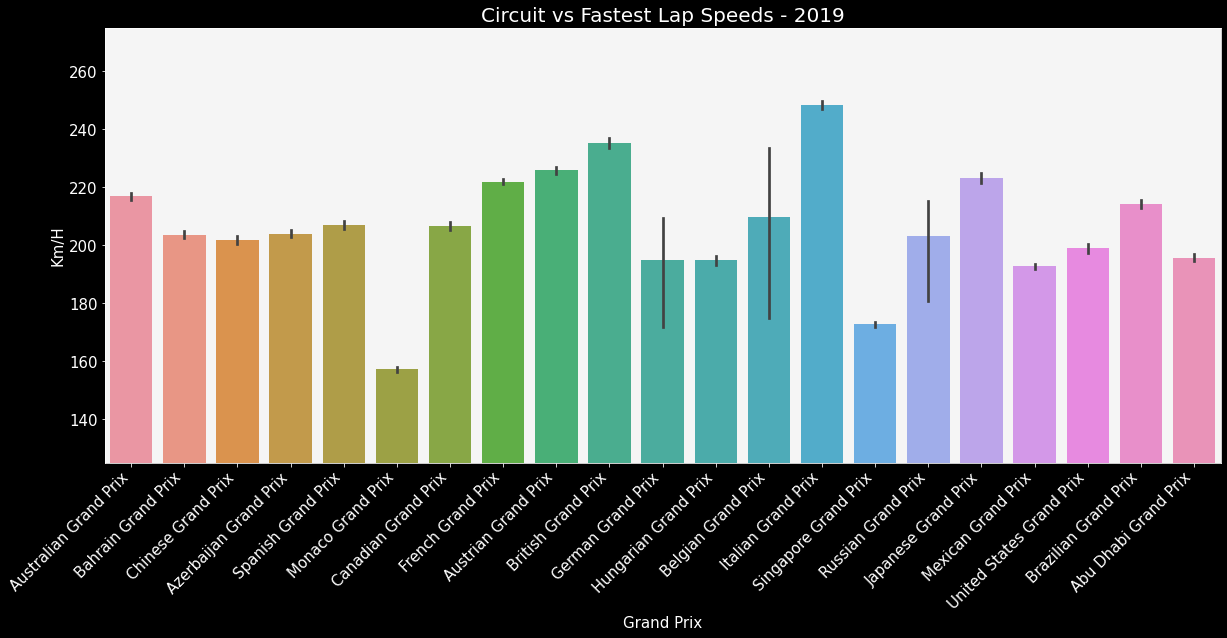

In [728]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize = (20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'GrandPrix', y = 'fastestLapSpeed', data = data_19)
plt.ylim(125, 275)
plt.title("Circuit vs Fastest Lap Speeds - 2019", fontsize = 20)
plt.xlabel('Grand Prix', fontsize = 15)
plt.ylabel('Km/H', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

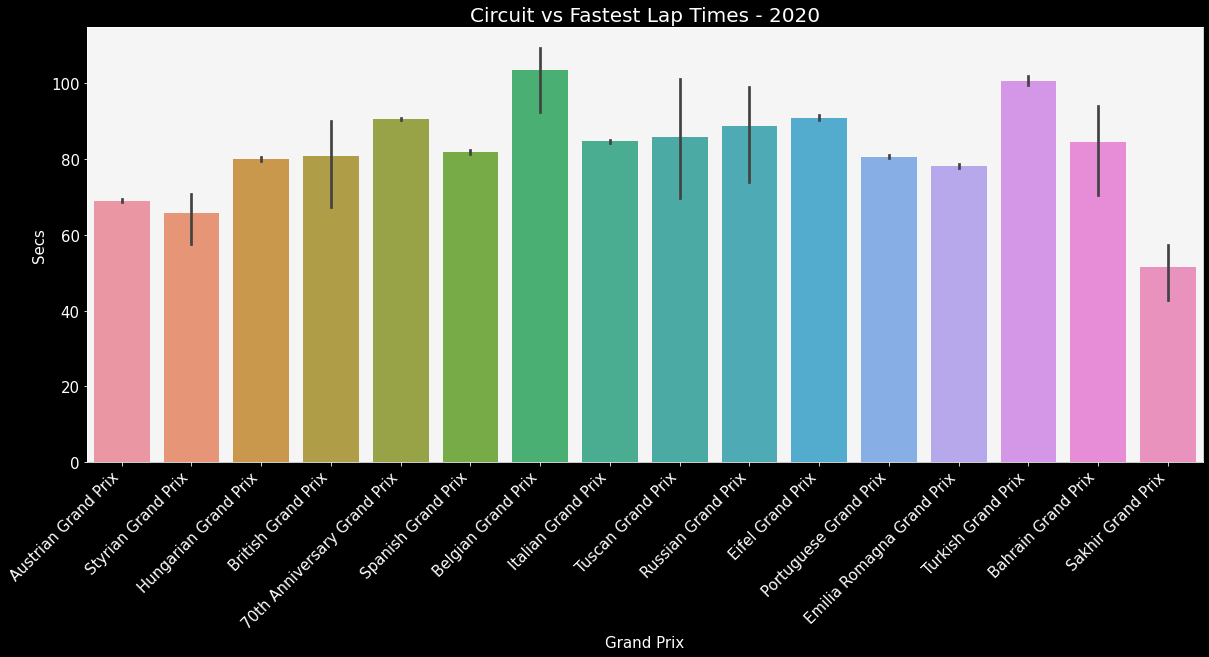

In [729]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 8))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'GrandPrix', y = 'fastestLapTime', data = data_20)
plt.title("Circuit vs Fastest Lap Times - 2020",fontsize = 20)
plt.xlabel('Grand Prix', fontsize = 15)
plt.ylabel('Secs', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

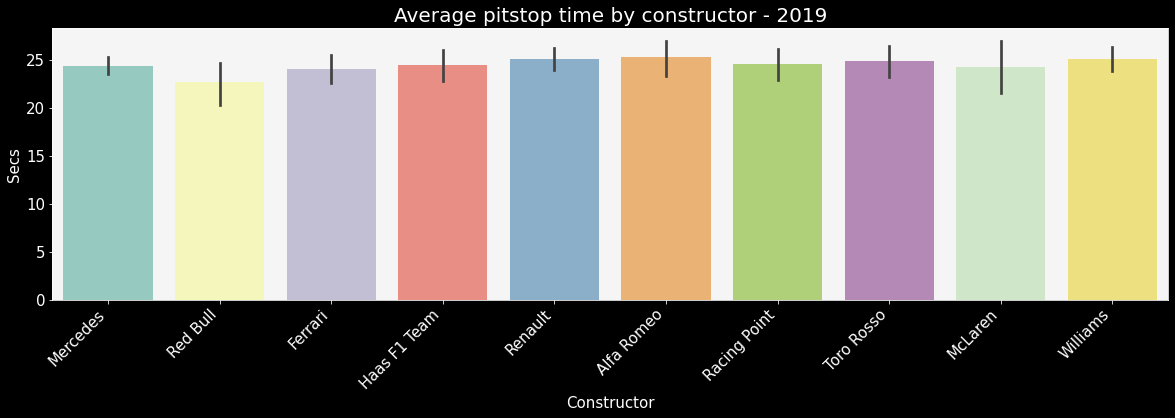

In [730]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 5))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'constructor', y = 'pitStopDuration', data = data_19)
plt.title("Average pitstop time by constructor - 2019",fontsize = 20)
plt.xlabel('Constructor', fontsize = 15)
plt.ylabel('Secs', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

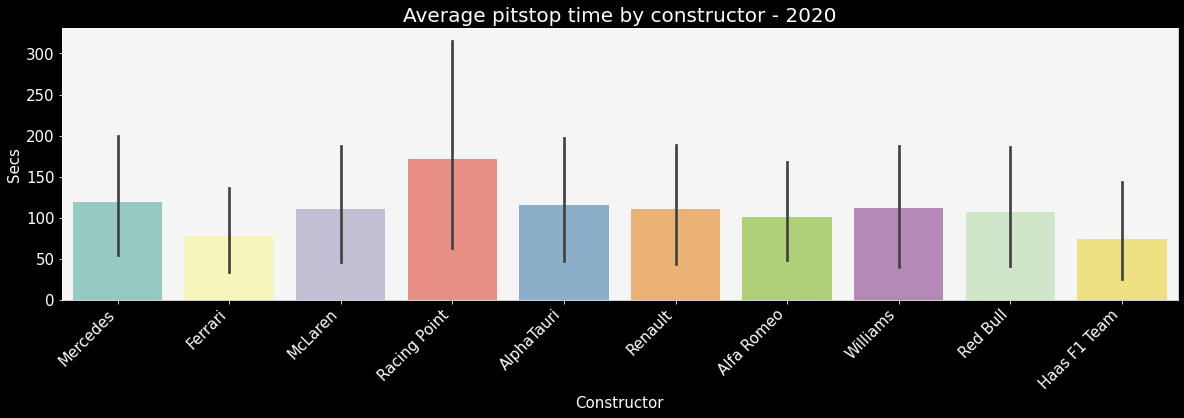

In [731]:
plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(20, 5))
axs.tick_params(axis = "x", labelsize = 15)
axs.tick_params(axis = "y", labelsize = 15)
axs.set_facecolor('whitesmoke')

sns.barplot(x = 'constructor', y = 'pitStopDuration', data = data_20)
plt.title("Average pitstop time by constructor - 2020",fontsize = 20)
plt.xlabel('Constructor', fontsize = 15)
plt.ylabel('Secs', fontsize = 15)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

2020 season saw a lot of red flags which caused the average pit stop time to go higher.

# Model Building

In [733]:
# data_backup = data.copy()
# data_backup.to_csv('final_data.csv', index = False)

data = pd.read_csv('final_data.csv')

<AxesSubplot:>

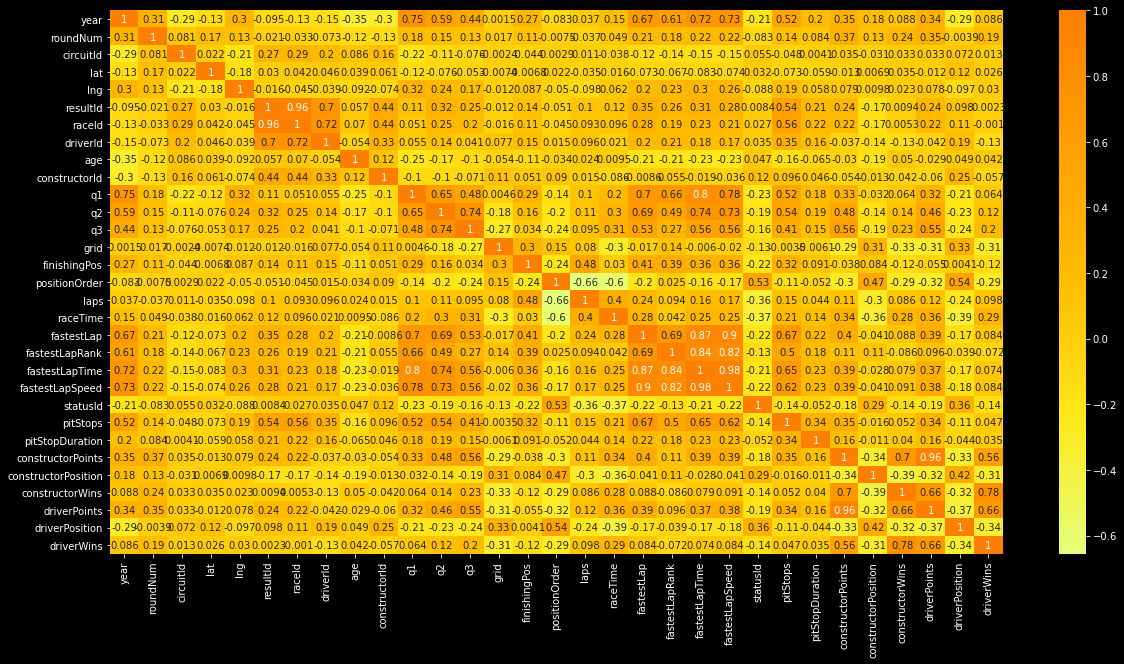

In [734]:
corrplot = data.corr()
plt.style.use("dark_background")
plt.figure(figsize = (20, 10))
sns.heatmap(corrplot, cmap = "Wistia", annot = True)

In [735]:
data = data.drop(['circuitId', 'circuitName', 'lat', 'lng', 'GrandPrix', 'driverRef', 'fullName', 'driverNationality', 'constructor', 
                  'constructorNationality', 'positionOrder'], axis = 1)
data = pd.get_dummies(data = data, prefix = 'circuit', prefix_sep = '_', columns = ['circuitRef'], drop_first = False)
data = pd.get_dummies(data = data, prefix = 'constructor', prefix_sep = '_', columns = ['constructorRef'], drop_first = False)

In [736]:
data.head()

year  roundNum  resultId  raceId  driverId  age  constructorId   q1   q2  \
0  1950         1     20025     833       642   44             51  0.0  0.0   
1  1950         1     20026     833       786   52             51  0.0  0.0   
2  1950         1     20027     833       686   39             51  0.0  0.0   
3  1950         1     20028     833       704   46            154  0.0  0.0   
4  1950         1     20029     833       627   45            154  0.0  0.0   

    q3  grid  finishingPos  laps  raceTime  fastestLap  fastestLapRank  \
0  0.0     1             1    70   8003600           0               0   
1  0.0     2             2    70   8006200           0               0   
2  0.0     4             3    70   8055600           0               0   
3  0.0     6             4    68         0           0               0   
4  0.0     9             5    68         0           0               0   

   fastestLapTime  fastestLapSpeed  statusId  pitStops  pitStopDuration  \
0             0.0              0.0         1       0.0              0.0   
1             0.0              0.0         1       0.0              0.0   
2             0.0              0.0         1       0.0              0.0   
3             0.0              0.0        12       0.0              0.0   
4             0.0              0.0        12       0.0              0.0   

   constructorPoints  constructorPosition  constructorWins  driverPoints  \
0                0.0                  0.0              0.0           9.0   
1                0.0                  0.0              0.0           6.0   
2                0.0                  0.0              0.0           4.0   
3                0.0                  0.0              0.0           3.0   
4                0.0                  0.0              0.0           2.0   

   driverPosition  driverWins  circuit_BAK  circuit_adelaide  \
0             1.0         1.0            0                 0   
1             2.0         0.0            0                 0   
2             3.0         0.0            0                 0   
3             4.0         0.0            0                 0   
4             5.0         0.0            0                 0   

   circuit_ain-diab  circuit_aintree  circuit_albert_park  circuit_americas  \
0                 0                0                    0                 0   
1                 0                0                    0                 0   
2                 0                0                    0                 0   
3                 0                0                    0                 0   
4                 0                0                    0                 0   

   circuit_anderstorp  circuit_avus  circuit_bahrain  circuit_boavista  \
0                   0             0                0                 0   
1                   0             0                0                 0   
2                   0             0                0                 0   
3                   0             0                0                 0   
4                   0             0                0                 0   

   circuit_brands_hatch  circuit_bremgarten  circuit_buddh  circuit_catalunya  \
0                     0                   0              0                  0   
1                     0                   0              0                  0   
2                     0                   0              0                  0   
3                     0                   0              0                  0   
4                     0                   0              0                  0   

   circuit_charade  circuit_dallas  circuit_detroit  circuit_dijon  \
0                0               0                0              0   
1                0               0                0              0   
2                0               0                0              0   
3                0               0                0              0   
4                0               

In [737]:
data.tail(20)

year  roundNum  resultId  raceId  driverId  age  constructorId    q1  \
24920  2020        16     24926    1046       815   30            211  54.2   
24921  2020        16     24927    1046       839   24              4  54.3   
24922  2020        16     24928    1046       840   22            211  54.6   
24923  2020        16     24929    1046       832   26              1  54.5   
24924  2020        16     24930    1046       817   31              4  54.4   
24925  2020        16     24931    1046       848   24              9  54.6   
24926  2020        16     24932    1046       826   26            213  54.3   
24927  2020        16     24933    1046       822   31            131  53.9   
24928  2020        16     24934    1046       847   22            131  54.2   
24929  2020        16     24935    1046       846   21              1  54.2   
24930  2020        16     24936    1046       842   24            213  54.2   
24931  2020        16     24937    1046        20   33              6  54.3   
24932  2020        16     24938    1046       841   27             51  54.5   
24933  2020        16     24939    1046         8   41             51  55.0   
24934  2020        16     24940    1046       825   28            210  54.7   
24935  2020        16     24941    1046       851   25              3  54.9   
24936  2020        16     24942    1046       850   24            210  55.4   
24937  2020        16     24943    1046       849   25              3  54.8   
24938  2020        16     24944    1046       830   23              9  54.0   
24939  2020        16     24945    1046       844   23              6  54.2   

         q2    q3  grid  finishingPos  laps  raceTime  fastestLap  \
24920  53.8  53.8     5             1    87   5475114          69   
24921  54.0   0.0    11             2    87   5485632          75   
24922  53.8  54.2    10             3    87   5486983          85   
24923  53.8  54.0     8             4    87   5487694          80   
24924  53.9  54.0     7             5    87   5488444          57   
24925  54.0   0.0    12             6    87   5488956          52   
24926  53.9  53.9     6             7    87   5489648          80   
24927  53.8  53.4     1             8    87   5490503          60   
24928  53.8  53.4     2             9    87   5493670          80   
24929  54.7   0.0    19            10    87   5494655          85   
24930  53.9  54.2     9            11    87   5495641          53   
24931  54.2   0.0    13            12    87   5497725          56   
24932  54.4   0.0    14            13    87   5499225          56   
24933   0.0   0.0    18            14    87   5501267          56   
24934   0.0   0.0    15            15    87   5507484          57   
24935   0.0   0.0    17            16    87   5508788          56   
24936   0.0   0.0    20            17    87   5511972          56   
24937   0.0   0.0    16             0    52         0          29   
24938  53.6  53.4     3             0     0         0           0   
24939  53.8  53.6     4             0     0         0           0   

       fastestLapRank  fastestLapTime  fastestLapSpeed  statusId  pitStops  \
24920               3            56.8          224.599         1       2.0   
24921              12            57.3          222.402         1       1.0   
24922              14            57.4          222.255         1       1.0   
24923               9            57.2          223.122         1       2.0   
24924               6            57.0          223.850         1       2.0   
24925               8            57.1          223.548         1       2.0   
24926               7            57.0          223.764         1       2.0   
24927               2            56.6          225.497         1       2.0   
24928               1            55.4          230.214         1       4.0   
24929              11            57.3          222.713         1       2.0   
24930              10            57.2  

In [738]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24940 entries, 0 to 24939
Columns: 310 entries, year to constructor_zakspeed
dtypes: float64(13), int64(14), uint8(283)
memory usage: 11.9 MB


In [739]:
train = data[data['year']<2020]
test = data[data['year']>2019]

x_train = train.drop(['finishingPos'], axis = 1)
y_train = train['finishingPos']

x_test = test.drop(['finishingPos'], axis = 1)
y_test = test['finishingPos']

In [740]:
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

In [741]:
xgb_model = xgb.XGBClassifier(n_estimators = 50, random_state = 0, seed = None, silent = True, subsample = 0.6)
xgb_model.fit(x_train, y_train)

[16:39:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, silent=True,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [742]:
y_pred = xgb_model.predict(x_test)

In [743]:
print('Model Accuracy is {}'.format(accuracy_score(y_test, y_pred)*1e2))
print(classification_report(y_test, y_pred))

Model Accuracy is 34.375
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       0.67      0.62      0.65        16
           2       0.44      0.44      0.44        16
           3       0.25      0.19      0.21        16
           4       0.13      0.12      0.13        16
           5       0.14      0.19      0.16        16
           6       0.09      0.12      0.10        16
           7       0.25      0.31      0.28        16
           8       0.13      0.12      0.13        16
           9       0.23      0.19      0.21        16
          10       0.25      0.19      0.21        16
          11       0.10      0.06      0.08        16
          12       0.11      0.19      0.14        16
          13       0.09      0.07      0.08        15
          14       0.23      0.21      0.22        14
          15       0.21      0.21      0.21        14
          16       0.23      0.25      0.24        12
  

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<AxesSubplot:>

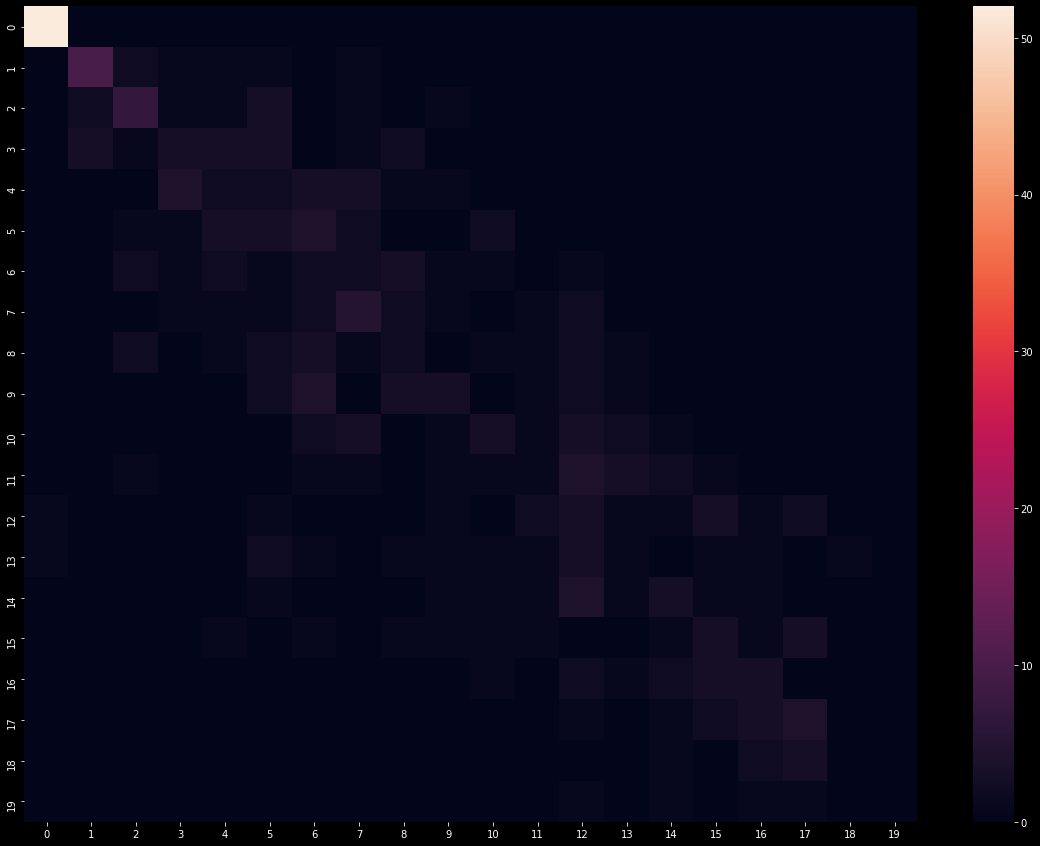

In [744]:
plt.figure(figsize = (20, 15))
sns.heatmap(confusion_matrix(y_test, y_pred))

In [745]:
output = x_test.copy()
output = output[['year', 'roundNum', 'raceId', 'driverId', 'constructorId', 'grid']]
output['y_pred'] = y_pred
output['y_actual'] = y_test
output = pd.merge(output, drivers[['driverId', 'fullName']], on = 'driverId', how = 'left')
output = pd.merge(output, constructors[['constructorId', 'name']], on = 'constructorId', how = 'left')
output = pd.merge(output, races[['raceId', 'name']], on = 'raceId', how = 'left')
output = output.rename(columns = {'year': 'Year', 'roundNum':'Round', 'grid': 'QualifyingGrid',
                                  'name_x': 'Constructor', 'name_y': 'GrandPrix', 'y_actual': 'FinalPosition',
                                  'y_pred': 'Prediction', 'fullName': 'Driver'}, inplace = False)
output = output[['Year', 'Round', 'GrandPrix', 'Constructor', 'Driver', 'QualifyingGrid', 'FinalPosition', 'Prediction']]
output
# output.to_csv('output.csv', index = False)

Year  Round            GrandPrix   Constructor             Driver  \
0    2020      1  Austrian Grand Prix      Mercedes    Valtteri Bottas   
1    2020      1  Austrian Grand Prix       Ferrari    Charles Leclerc   
2    2020      1  Austrian Grand Prix       McLaren       Lando Norris   
3    2020      1  Austrian Grand Prix      Mercedes     Lewis Hamilton   
4    2020      1  Austrian Grand Prix       McLaren       Carlos Sainz   
..    ...    ...                  ...           ...                ...   
315  2020     16    Sakhir Grand Prix      Williams        Jack Aitken   
316  2020     16    Sakhir Grand Prix  Haas F1 Team  Pietro Fittipaldi   
317  2020     16    Sakhir Grand Prix      Williams    Nicholas Latifi   
318  2020     16    Sakhir Grand Prix      Red Bull     Max Verstappen   
319  2020     16    Sakhir Grand Prix       Ferrari    Charles Leclerc   

     QualifyingGrid  FinalPosition  Prediction  
0                 1              1           1  
1                 7              2           2  
2                 3              3           3  
3                 5              4           4  
4                 8              5           5  
..              ...            ...         ...  
315              17             16          12  
316              20             17          12  
317              16              0           0  
318               3              0           0  
319               4              0           0  

[320 rows x 8 columns]

In [746]:
podium = []

for x in data['finishingPos']:
    if x == 1:
        podium.append(1)
    elif x == 2:
        podium.append(1)
    elif x == 3:
        podium.append(1)
    else:
        podium.append(0)

data['podium'] = podium

In [747]:
train = data[data['year']<2020]
test = data[data['year']>2019]

x_train = train.drop(['finishingPos', 'podium'], axis = 1)
y_train = train['podium']

x_test = test.drop(['finishingPos', 'podium'], axis = 1)
y_test = test['podium']

In [748]:
xgb_model = xgb.XGBClassifier(n_estimators = 100, random_state = 0, seed = None, silent = True, subsample = 0.6)
xgb_model.fit(x_train, y_train)

[16:40:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [749]:
y_pred = xgb_model.predict(x_test)

In [750]:
print('Model Accuracy is {}'.format(accuracy_score(y_test, y_pred)*1e2))
print(classification_report(y_test, y_pred))

Model Accuracy is 92.5
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       272
           1       0.80      0.67      0.73        48

    accuracy                           0.93       320
   macro avg       0.87      0.82      0.84       320
weighted avg       0.92      0.93      0.92       320



<AxesSubplot:>

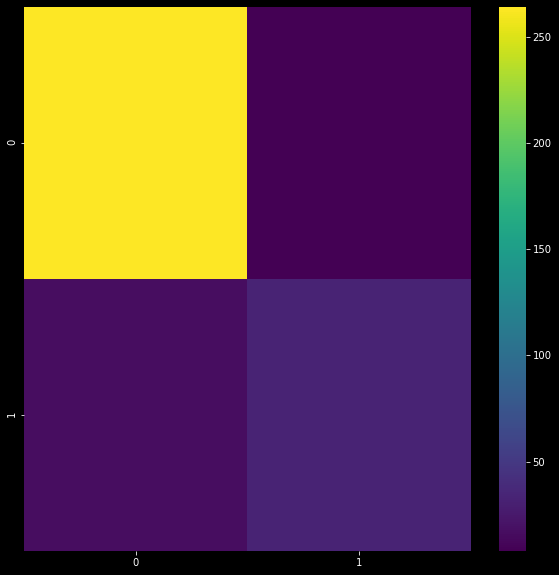

In [751]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap = "viridis")

In [752]:
output = x_test.copy()
output = output[['year', 'roundNum', 'raceId', 'driverId', 'constructorId', 'grid']]
output['y_pred'] = y_pred
output['y_actual'] = y_test
output = pd.merge(output, drivers[['driverId', 'fullName']], on = 'driverId', how = 'left')
output = pd.merge(output, constructors[['constructorId', 'name']], on = 'constructorId', how = 'left')
output = pd.merge(output, races[['raceId', 'name']], on = 'raceId', how = 'left')
output = output.rename(columns = {'year': 'Year', 'roundNum':'Round', 'grid': 'QualifyingGrid',
                                  'name_x': 'Constructor', 'name_y': 'GrandPrix', 'y_actual': 'FinalPosition',
                                  'y_pred': 'Prediction', 'fullName': 'Driver'}, inplace = False)
output = output[['Year', 'Round', 'GrandPrix', 'Constructor', 'Driver', 'QualifyingGrid', 'FinalPosition', 'Prediction']]
output
# output.to_csv('output.csv', index = False)

Year  Round            GrandPrix   Constructor             Driver  \
0    2020      1  Austrian Grand Prix      Mercedes    Valtteri Bottas   
1    2020      1  Austrian Grand Prix       Ferrari    Charles Leclerc   
2    2020      1  Austrian Grand Prix       McLaren       Lando Norris   
3    2020      1  Austrian Grand Prix      Mercedes     Lewis Hamilton   
4    2020      1  Austrian Grand Prix       McLaren       Carlos Sainz   
..    ...    ...                  ...           ...                ...   
315  2020     16    Sakhir Grand Prix      Williams        Jack Aitken   
316  2020     16    Sakhir Grand Prix  Haas F1 Team  Pietro Fittipaldi   
317  2020     16    Sakhir Grand Prix      Williams    Nicholas Latifi   
318  2020     16    Sakhir Grand Prix      Red Bull     Max Verstappen   
319  2020     16    Sakhir Grand Prix       Ferrari    Charles Leclerc   

     QualifyingGrid  FinalPosition  Prediction  
0                 1              1           1  
1                 7              1           0  
2                 3              1           1  
3                 5              0           0  
4                 8              0           0  
..              ...            ...         ...  
315              17              0           0  
316              20              0           0  
317              16              0           0  
318               3              0           0  
319               4              0           0  

[320 rows x 8 columns]